# 1 IMPORTS

In [1]:
%matplotlib inline

# Dataset
import pickle
import warnings
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
from IPython.display     import Image

# Análises multivariadas
from tabulate    import tabulate
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# Transformação dos dados
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from boruta                  import BorutaPy
from sklearn.ensemble        import ExtraTreesClassifier

# Machine learning
from sklearn              import ensemble as en
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import RandomForestClassifier
import xgboost            as xgb
from catboost             import CatBoostClassifier
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB

# Avaliação do modelo
from sklearn                 import metrics
from sklearn.metrics         import roc_auc_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.metrics         import precision_score, recall_score
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import classification_report, roc_curve, brier_score_loss
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

## 1.1 Definição de funções

In [2]:
# configurações do Seaborn
sns.set_palette('tab10')
sns.set_style('darkgrid')

# média das datas 
def data_mean(x):
    if x['altura'] < 1:
        mean = df1['altura'].loc[(df1['altura'] >= 1) & (df1['altura'] <= 2.1)].mean()
        return round(mean,2)
    elif x['altura'] > 2.1:
        mean = df1['altura'].loc[(df1['altura'] >= 1) & (df1['altura'] <= 2.1)].mean()
        return round(mean,2)
    else:
        return x['altura']

# Padrão para plotagens    
def data_load(ax1, title, xlabel, ylabel):
    ax1.set_title(title, fontdict={'fontsize': 18})
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 15})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 15})
    return None


# Classe para correlação e métricas
class Utilities(object):
    def cramerv(self, var_x, var_y):
        # matriz da confusão
        confusion_matrix_v = pd.crosstab(var_x, var_y).values

        # soma de todos os valores da matriz
        n = confusion_matrix_v.sum()

        # linha e coluna
        l, c = confusion_matrix_v.shape

        # qui-quadrado
        chi2 = chi2_contingency(confusion_matrix_v)[0]

        # correção 
        chi2corr = max(0, chi2 - (c-1) * (l-1) / (n-1))
        ccorr = c - (c-1) ** 2 / (n-1)
        lcorr = l - (l-1) ** 2 / (n-1)

        # retornar ao crame v
        return np.sqrt((chi2corr/n) / min(ccorr-1, lcorr-1))

    # performance de modelos de classificação 
    def performance_modelo(self, X_train, X_test, y_train, y_test, threshold, classifiers):

        dataframe_performance = pd.DataFrame()

        for clf in classifiers:
            print("Training " + type(clf).__name__ + "...")
            
            clf.fit(X_train, y_train)

            clf_probs = clf.predict_proba(X_test)

            clf_accuracy, clf_kappa, clf_f1, clf_auc, clf_precision, clf_recall = self.calculo_metricas_modelos(clf,
                                                                                                               X_test, y_test,
                                                                                                               clf_probs, threshold)

            clf_dict = {
                'model': [type(clf).__name__, '---'],
                'precision': [clf_precision, np.nan],
                'recall': [clf_recall, np.nan],
                'f1-Score': [clf_f1, np.nan],
                'ROC AUC': [clf_auc, np.nan],
                'accuracy': [clf_accuracy, np.nan],
                'cohen kappa': [clf_kappa, np.nan]}

            dataframe_performance = pd.concat([dataframe_performance, pd.DataFrame(clf_dict)])

        dataframe_performance = dataframe_performance.reset_index()

        dataframe_performance.drop('index', axis=1, inplace=True)

        rows_to_drop = np.arange(1, len(classifiers)*2, 2)

        dataframe_performance.drop(rows_to_drop, inplace=True)

        return dataframe_performance

    def calculo_metricas_modelos(self, model, X_test, y_test, model_probs, threshold):
        """
            Calcular Acurácia, F1-Score, PR AUC
        """
        probs = pd.DataFrame(model_probs[:, 1], columns=['prob'])

        y_pred = probs['prob'].apply(lambda x: 1 if x > threshold else 0)

        f1 = f1_score(y_test, y_pred)

        accuracy = accuracy_score(y_test, y_pred)

        kappa = cohen_kappa_score(y_test, y_pred)

        auc_score = roc_auc_score(y_test, probs)

        precision = precision_score(y_test, y_pred)

        recall = recall_score(y_test, y_pred)

        return accuracy, kappa, f1, auc_score, precision, recall 


In [3]:
# Classe de utilidades
UG = Utilities()

## 1.2 Carregando Dados

In [4]:
df1 = pd.read_csv('dataset/cardio_train.csv', sep=';')

# 2 Descrição dos dados

## 2.1 Observação dos dados

In [5]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2.2 Formatação

In [6]:
# Checando colunas
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [7]:
df1.columns = ['id', 'idade', 'genero', 'altura', 'peso', 'pressao_arterial_sistolica', 'pressao_sanguinea_diastolica',
       'colesterol', 'glicose', 'fuma', 'alcool', 'atividade_fisica', 'presenca_ou_ausencia_de_doença_cardiovascular']
df1.head()

,id,idade,genero,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,colesterol,glicose,fuma,alcool,atividade_fisica,presenca_ou_ausencia_de_doença_cardiovascular
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Vamos colocar a ferramenta **altura** em metros para facilitar a visualização e criar uma ferramenta de **idade** nova chamada **Idade_2** para não perder informação futuramente na coluna atual que está em quantidade de dias.

In [8]:
df1['altura'] = round(df1['altura']/100,2)
df1['idade_2'] = round(df1['idade']/365, 1)  
df1.head(5)

,id,idade,genero,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,colesterol,glicose,fuma,alcool,atividade_fisica,presenca_ou_ausencia_de_doença_cardiovascular,idade_2
0,0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,50.4
1,1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,55.4
2,2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,51.7
3,3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,48.3
4,4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,47.9


## 2.3 Tipos dos dados

In [9]:
df1.dtypes

id                                                 int64
idade                                              int64
genero                                             int64
altura                                           float64
peso                                             float64
pressao_arterial_sistolica                         int64
pressao_sanguinea_diastolica                       int64
colesterol                                         int64
glicose                                            int64
fuma                                               int64
alcool                                             int64
atividade_fisica                                   int64
presenca_ou_ausencia_de_doença_cardiovascular      int64
idade_2                                          float64
dtype: object

In [10]:
df1['genero'] = df1['genero'].astype( str )

a = pd.CategoricalDtype(categories=[1, 2, 3], ordered=True)
df1['colesterol'] = df1['colesterol'].astype( a )

b = pd.CategoricalDtype(categories=[1, 2, 3], ordered=True)
df1['glicose'] = df1['glicose'].astype( b )

df1['fuma'] = df1['fuma'].astype( str )

df1['alcool'] = df1['alcool'].astype( str )

df1['atividade_fisica'] = df1['atividade_fisica'].astype( str )

df1['presenca_ou_ausencia_de_doença_cardiovascular'] = df1['presenca_ou_ausencia_de_doença_cardiovascular'].astype( str )

In [11]:
df1.dtypes

id                                                  int64
idade                                               int64
genero                                             object
altura                                            float64
peso                                              float64
pressao_arterial_sistolica                          int64
pressao_sanguinea_diastolica                        int64
colesterol                                       category
glicose                                          category
fuma                                               object
alcool                                             object
atividade_fisica                                   object
presenca_ou_ausencia_de_doença_cardiovascular      object
idade_2                                           float64
dtype: object

## 2.4 Checando e Tratando os dados vazios

In [12]:
df1.isna().sum()

id                                               0
idade                                            0
genero                                           0
altura                                           0
peso                                             0
pressao_arterial_sistolica                       0
pressao_sanguinea_diastolica                     0
colesterol                                       0
glicose                                          0
fuma                                             0
alcool                                           0
atividade_fisica                                 0
presenca_ou_ausencia_de_doença_cardiovascular    0
idade_2                                          0
dtype: int64

## 3 Estatística descritiva

### 3.1 Atributos Numéricos
**1**. Vamos criar 2 ferramentas para visualizar melhor as estatísticas de curtose e simetria.

**2**. Percebemos um valor muito alto na curtose de Pressão arterial sistólica e Pressão sanguínea diastólica devido a presença de outliers.

**3**. Nas ferramentas altura e Peso existem alguns outliers nos valores mínimos e máximos.

In [13]:
# Selecionando dados int e float
NA = df1.select_dtypes(['int32','int64', 'float64'])

In [14]:
# Criando recurso de simetria 
Simetria = pd.DataFrame(NA.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

# Criando recurso de curtose
Curtose = pd.DataFrame(NA.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA.describe().round(2)
m = pd.concat([describe, Simetria, Curtose], axis=0)
m.iloc[:,1:]

,idade,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,idade_2
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00
mean,19468.87,1.64,74.21,128.82,96.63,53.34
std,2467.25,0.08,14.40,154.01,188.47,6.76
min,10798.00,0.55,10.00,-150.00,-70.00,29.60
25%,17664.00,1.59,65.00,120.00,80.00,48.40
50%,19703.00,1.65,72.00,120.00,80.00,54.00
75%,21327.00,1.70,82.00,140.00,90.00,58.40
max,23713.00,2.50,200.00,16020.00,11000.00,65.00
Simetria,-0.31,-0.64,1.01,85.30,32.11,-0.31
Curtose,-0.82,7.94,2.59,7580.07,1425.91,-0.82


In [15]:
# Criando classe de curtose
Classe_curtose = pd.DataFrame(m.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

#Criando classe de simetria
Classe_simetria = pd.DataFrame(m.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m = pd.concat([m, Classe_curtose, Classe_simetria], axis=0)
m.iloc[:,1:]

,idade,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,idade_2
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0
mean,19468.87,1.64,74.21,128.82,96.63,53.34
std,2467.25,0.08,14.4,154.01,188.47,6.76
min,10798.0,0.55,10.0,-150.0,-70.0,29.6
25%,17664.0,1.59,65.0,120.0,80.0,48.4
50%,19703.0,1.65,72.0,120.0,80.0,54.0
75%,21327.0,1.7,82.0,140.0,90.0,58.4
max,23713.0,2.5,200.0,16020.0,11000.0,65.0
Simetria,-0.31,-0.64,1.01,85.3,32.11,-0.31
Curtose,-0.82,7.94,2.59,7580.07,1425.91,-0.82


### 3.2 Atributos Categóricos

In [16]:
# Selecionando dados 'object' e 'category'
CA = df1.select_dtypes(['object','category'])
CA.apply( lambda x: x.unique().shape[0] )

genero                                           2
colesterol                                       3
glicose                                          3
fuma                                             2
alcool                                           2
atividade_fisica                                 2
presenca_ou_ausencia_de_doença_cardiovascular    2
dtype: int64

# 4 Filtrando o quadro de dados

Removeremos os outliers através da implementação da média nas **alturas** selecionadas abaixo devido à quantidade ser baixa e os outros como o **Peso**, **Pressão sanguínea diastólica** e **Pressão sanguínea sistólica** vamos remover, pois não temos como inserir outros valores com essas quantidades.

## 4.1 Checando valores discrepantes dos dados numéricos

In [17]:
df2 = df1.copy()

df1.to_csv('data_saves/df1.csv', index=False)

Neste gráfico observamos pesos e alturas discrepantes como abaixo de 25kg ou altura menores que 1 metro e maiores que 2,5 metros.

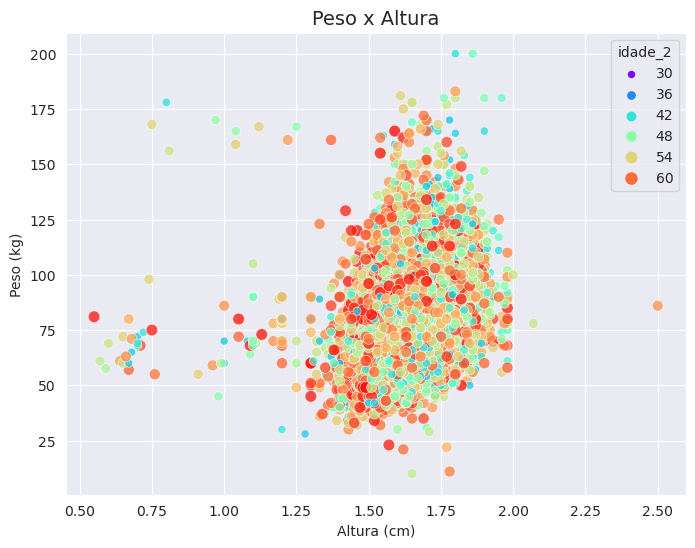

In [19]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='altura', y='peso', data=df2, hue='idade_2', palette='rainbow', size='idade_2', alpha=0.75)
plt.xlabel("Altura (cm)")
plt.ylabel("Peso (kg)")
plt.title("Peso x Altura", fontsize=14)

plt.show()

Neste gráfico observamos pesos e alturas discrepantes também como aproximadamente  200kg e alturas menores que 1,25 metros ou pesos abaixo de 25kg e idades perto dos 60 anos, algo bastante improvável.

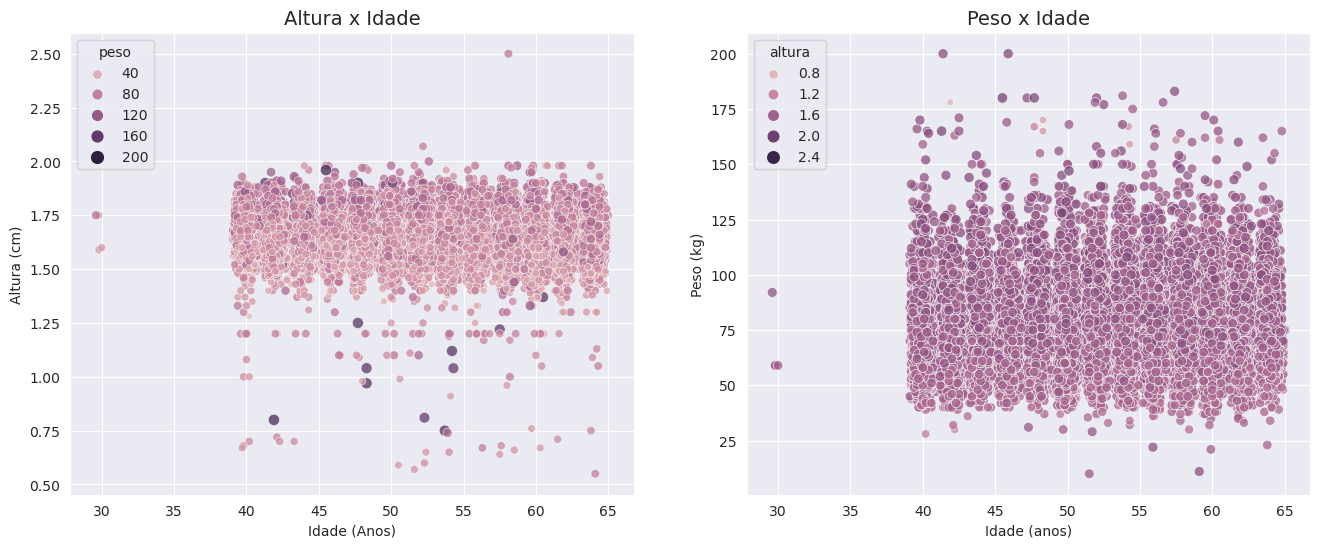

In [23]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.scatterplot(x='idade_2', y='altura', data=df2, hue='peso', size='peso', alpha=0.75)
plt.xlabel("Idade (Anos)")
plt.ylabel("Altura (cm)")
plt.title("Altura x Idade", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x='idade_2', y='peso', data=df2, hue='altura', size='altura', alpha=0.75)
plt.xlabel("Idade (anos)")
plt.ylabel("Peso (kg)")
plt.title("Peso x Idade", fontsize=14)

plt.show()

Aqui observamos nitidamente pressões arteriais sistólicas e diastólicas acima dos 2000, ja iremos descartar. Olhando mais especificamente e seguindo as tabelas médicas podemos descartar pressões arteriais sistólicas abaixo de 60 ou acima de 150 e ressões arteriais diastólicas abaixo de 90 e acima de 210.

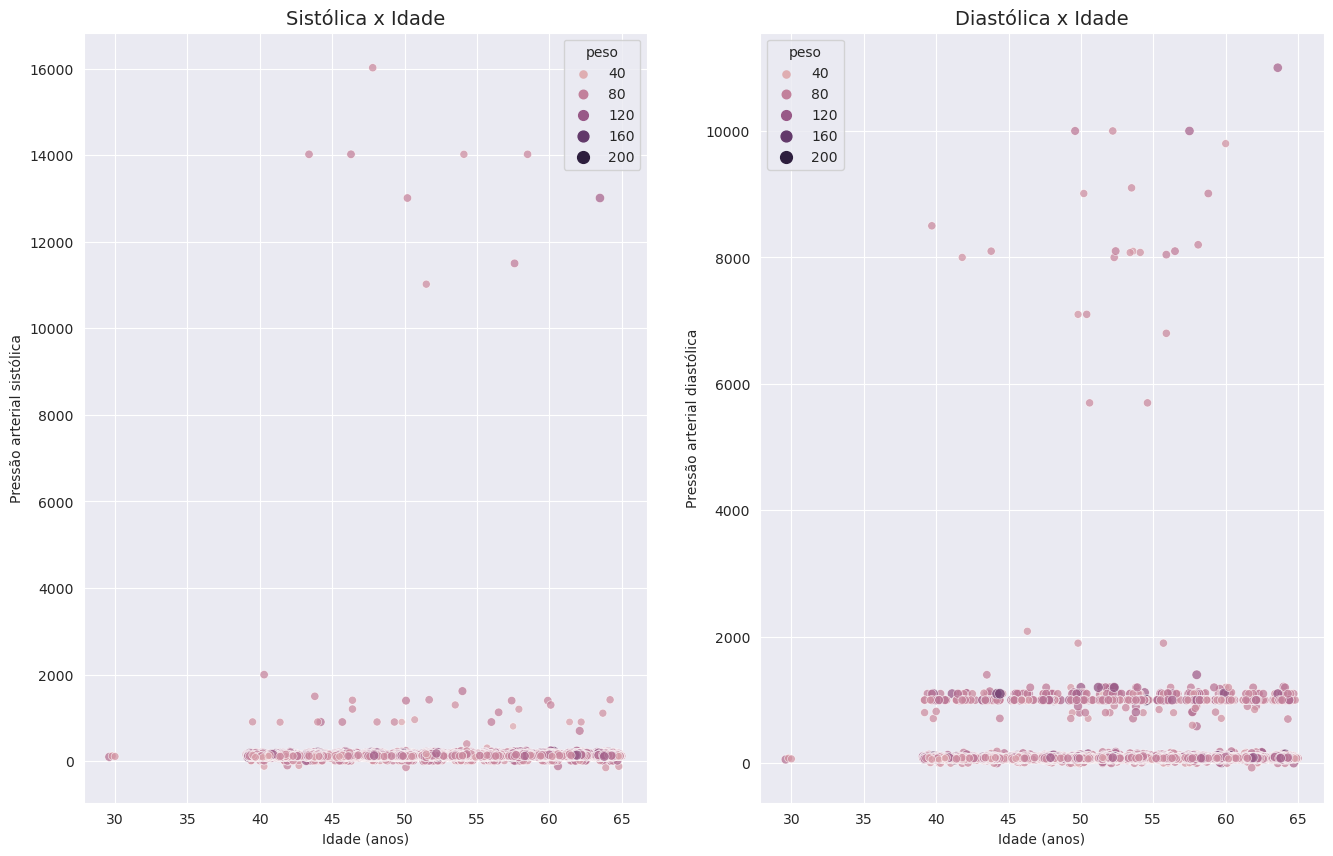

In [21]:
# sets plot size
plt.figure(figsize=(16,10))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='idade_2', y='pressao_arterial_sistolica', data=df2, hue='peso', size='peso', alpha=0.75)
plt.xlabel("Idade (anos)")
plt.ylabel("Pressão arterial sistólica")
plt.title("Sistólica x Idade", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x='idade_2', y='pressao_sanguinea_diastolica', data=df2, hue='peso', size='peso', alpha=0.75)
plt.xlabel("Idade (anos)")
plt.ylabel("Pressão arterial diastólica")
plt.title("Diastólica x Idade", fontsize=14)

# displays the plot
plt.show()

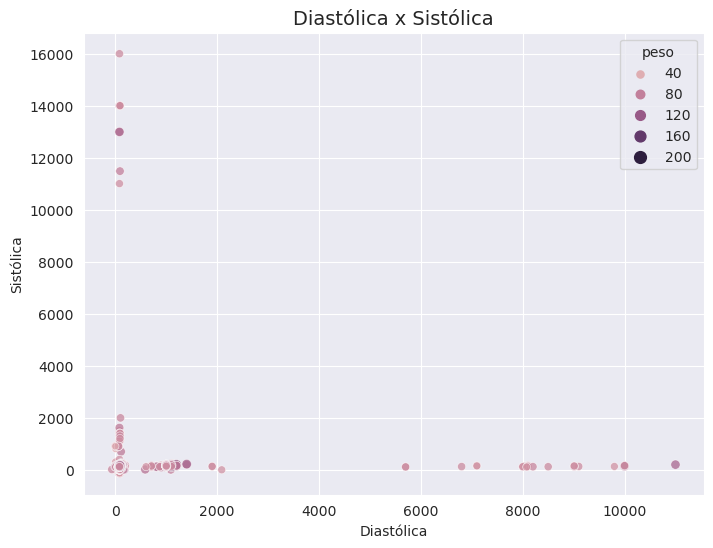

In [22]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='pressao_sanguinea_diastolica', y='pressao_arterial_sistolica', data=df2, hue='peso', size='peso', alpha=0.75)
plt.xlabel("Diastólica")
plt.ylabel("Sistólica")
plt.title("Diastólica x Sistólica", fontsize=14)

plt.show()

In [24]:
# Removendo outlierss
df2['altura'] = df2.apply(data_mean, axis=1)

data_remove = df2.loc[(df2['peso'] < 40) | (df2['peso'] > 150)] 
df2 = df2.drop(data_remove.index)

data_remove1 = df2.loc[(df2['pressao_sanguinea_diastolica'] < 60) | (df2['pressao_sanguinea_diastolica'] > 150)]
df2 = df2.drop(data_remove1.index)

data_remove2 = df2.loc[(df2['pressao_arterial_sistolica'] < 90) | (df2['pressao_arterial_sistolica'] > 210)]
df2 = df2.drop(data_remove2.index)

### 4.1.1 Checando
Após ajustarmos os **outliers** e os **NA** que não existiam, observamos que está tudo certo agora.

In [25]:
# Checando outliers e valores vazios
NA = df2.select_dtypes(['int32','int64', 'float64'])

Simetria = pd.DataFrame(NA.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

Curtose = pd.DataFrame(NA.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA.describe().round(2)
m = pd.concat([describe, Simetria, Curtose], axis=0)
m.iloc[:,1:]

,idade,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,idade_2
count,68392.00,68392.00,68392.00,68392.00,68392.00,68392.00
mean,19465.83,1.64,74.09,126.68,81.38,53.33
std,2466.94,0.08,14.05,16.48,9.36,6.76
min,10798.00,1.00,40.00,90.00,60.00,29.60
25%,17662.00,1.59,65.00,120.00,80.00,48.40
50%,19701.50,1.65,72.00,120.00,80.00,54.00
75%,21324.00,1.70,82.00,140.00,90.00,58.40
max,23713.00,2.07,150.00,210.00,150.00,65.00
Simetria,-0.31,-0.06,0.86,0.90,0.43,-0.31
Curtose,-0.82,1.20,1.36,1.43,1.89,-0.82


In [26]:
Classe_curtose = pd.DataFrame(m.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

Classe_simetria = pd.DataFrame(m.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m = pd.concat([m, Classe_curtose, Classe_simetria], axis=0)
m.iloc[:,1:]


,idade,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,idade_2
count,68392.0,68392.0,68392.0,68392.0,68392.0,68392.0
mean,19465.83,1.64,74.09,126.68,81.38,53.33
std,2466.94,0.08,14.05,16.48,9.36,6.76
min,10798.0,1.0,40.0,90.0,60.0,29.6
25%,17662.0,1.59,65.0,120.0,80.0,48.4
50%,19701.5,1.65,72.0,120.0,80.0,54.0
75%,21324.0,1.7,82.0,140.0,90.0,58.4
max,23713.0,2.07,150.0,210.0,150.0,65.0
Simetria,-0.31,-0.06,0.86,0.9,0.43,-0.31
Curtose,-0.82,1.2,1.36,1.43,1.89,-0.82


### 4.1.2 Checkpoint

In [27]:
# cópia do data set
df3 = df2.copy()

# salvar o data set 
df2.to_csv('data_saves/df2.csv', index=False)

# checar a dimensão do data set 
df3.shape

(68392, 14)

## 4.2 Mapa de Hipóteses

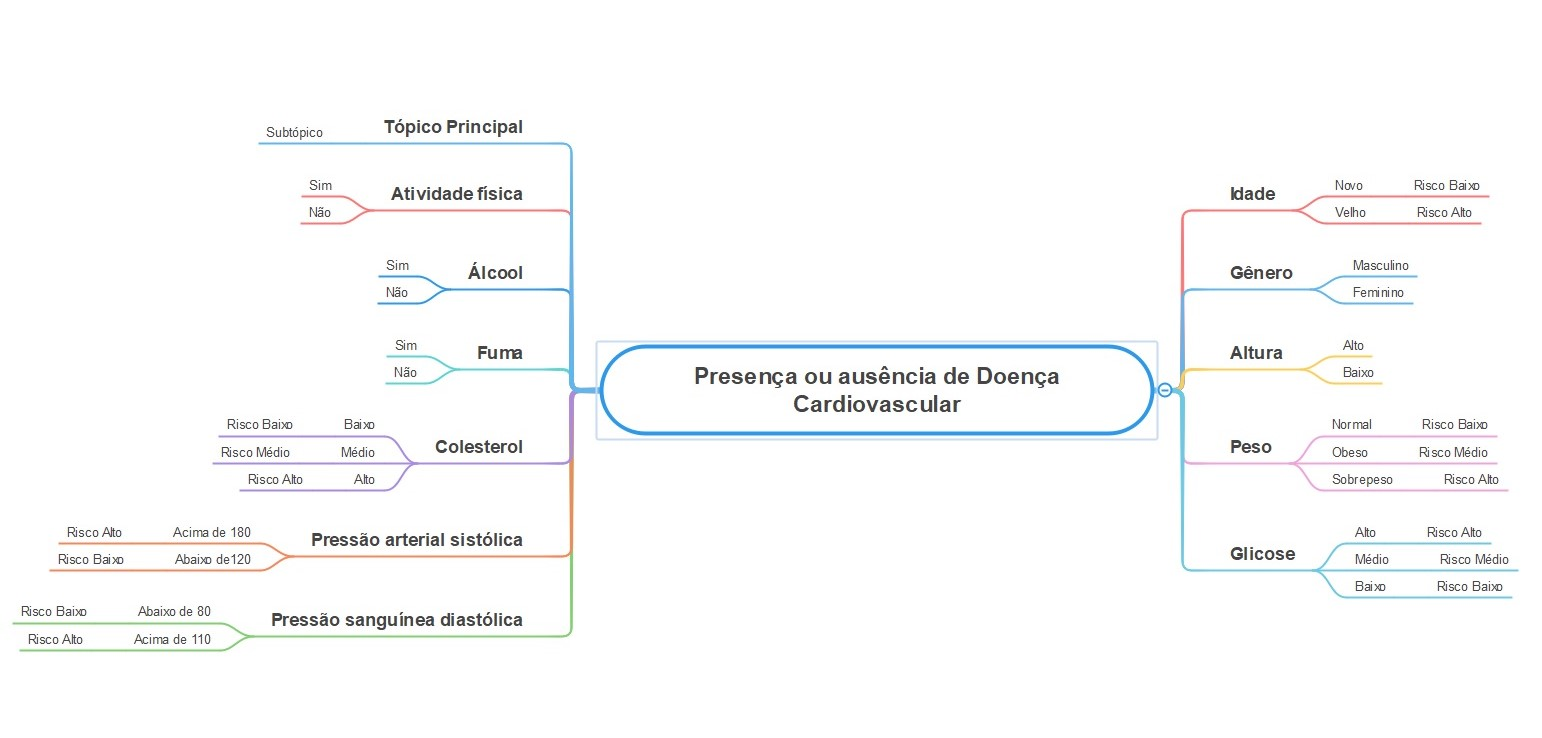

In [28]:
# Imagem do mapa de hipóteses
Image( 'images/Presença ou ausencia de Doença Cardiovascular.jpg' )

## 4.3 Engenharia de Recursos

Vamos adicionar ferramentas para facilitar os modelos de Machine Learning futuros e obter melhores resultados.

In [29]:
# Tabela de pressões
df3['tabela_pressoes'] = ''
for idx, _ in df3.iterrows():
    if (df3['pressao_arterial_sistolica'].at[idx]<120) & (df3['pressao_sanguinea_diastolica'].at[idx]<80):
        df3['tabela_pressoes'].at[idx]='Normal'
    elif (df3['pressao_arterial_sistolica'].at[idx]<140) | (df3['pressao_sanguinea_diastolica'].at[idx]<90):
        df3['tabela_pressoes'].at[idx]='PreHipertensão'
    elif (df3['pressao_arterial_sistolica'].at[idx]<160) | (df3['pressao_sanguinea_diastolica'].at[idx]<100):
        df3['tabela_pressoes'].at[idx]='Hipertensão1'
    elif (df3['pressao_arterial_sistolica'].at[idx]<=180) |(df3['pressao_sanguinea_diastolica'].at[idx]<=110):
        df3['tabela_pressoes'].at[idx]='Hipertensão2'
    else:
        df3['tabela_pressoes'].at[idx]='CriseHipertensiva'

#Valores do IMC(Índice Massa Corpórea)
Altura_quadrado = (df3['altura']*df3['altura'])
df3['IMC'] = np.divide(df3['peso'], Altura_quadrado)

# Categorias do IMC
df3['tabela_IMC'] = ''
for idx, _ in df3.iterrows():
    if (df3['IMC'].at[idx]<18.5):
        df3['tabela_IMC'].at[idx]='Abaixo do Peso'
    elif (df3['IMC'].at[idx]>=18.5) & (df3['IMC'].at[idx]<=24.9):
        df3['tabela_IMC'].at[idx]='Normal'
    elif (df3['IMC'].at[idx]>25) & (df3['IMC'].at[idx]<=29.9):
        df3['tabela_IMC'].at[idx]='Sobrepeso'
    else:
        df3['tabela_IMC'].at[idx]='Obesidade'

        
# Valor padrão de IMC
IMC_Normal = 21
# Criando feature diferença de IMC
df3['diferença_IMC'] = df3['IMC'] - IMC_Normal

df3.head()

,id,idade,genero,altura,peso,pressao_arterial_sistolica,pressao_sanguinea_diastolica,colesterol,glicose,fuma,alcool,atividade_fisica,presenca_ou_ausencia_de_doença_cardiovascular,idade_2,tabela_pressoes,IMC,tabela_IMC,diferença_IMC
0,0,18393,2,1.68,62.0,110,80,1,1,0,0,1,0,50.4,PreHipertensão,21.967120,Normal,0.967120
1,1,20228,1,1.56,85.0,140,90,3,1,0,0,1,1,55.4,Hipertensão1,34.927679,Obesidade,13.927679
2,2,18857,1,1.65,64.0,130,70,3,1,0,0,0,1,51.7,PreHipertensão,23.507805,Normal,2.507805
3,3,17623,2,1.69,82.0,150,100,1,1,0,0,1,1,48.3,Hipertensão1,28.710479,Sobrepeso,7.710479
4,4,17474,1,1.56,56.0,100,60,1,1,0,0,0,0,47.9,Normal,23.011177,Normal,2.011177


### 4.3.1 Checkpoint

In [94]:
# cópia do data set 
df4 = df3.copy()

# salvar o data set 
df3.to_csv('data_saves/df3.csv', index=False)

# 5 Questões e Hipóteses

**1**. Em cada classe de idade a maioria das pessoas não tem doença cardiovascular

**2**. Pessoas que fumam tem mais chances de ter Doença Cardiovascular

**3**. Mulheres tem mais chances de ter Doença Cardiovascular

**4**. Pessoas que fumam e bebem tem mais chances de ter Doença Cardiovascular

**5**. Pessoas que não fazem atividade física tem mais chances de ter Doença Cardiovascular

**6**. Pessoas mais pesadas tem mais chances de ter Doença Cardiovascular

# 6 Análise Exploratória dos Dados


## 6.1 Análises Univariadas

### 6.1.1 Variável Alvo

Nossas respostas, de acordo com o gráfico, são bem equilibradas facilitando as aplicações dos modelos de Machine Learning.

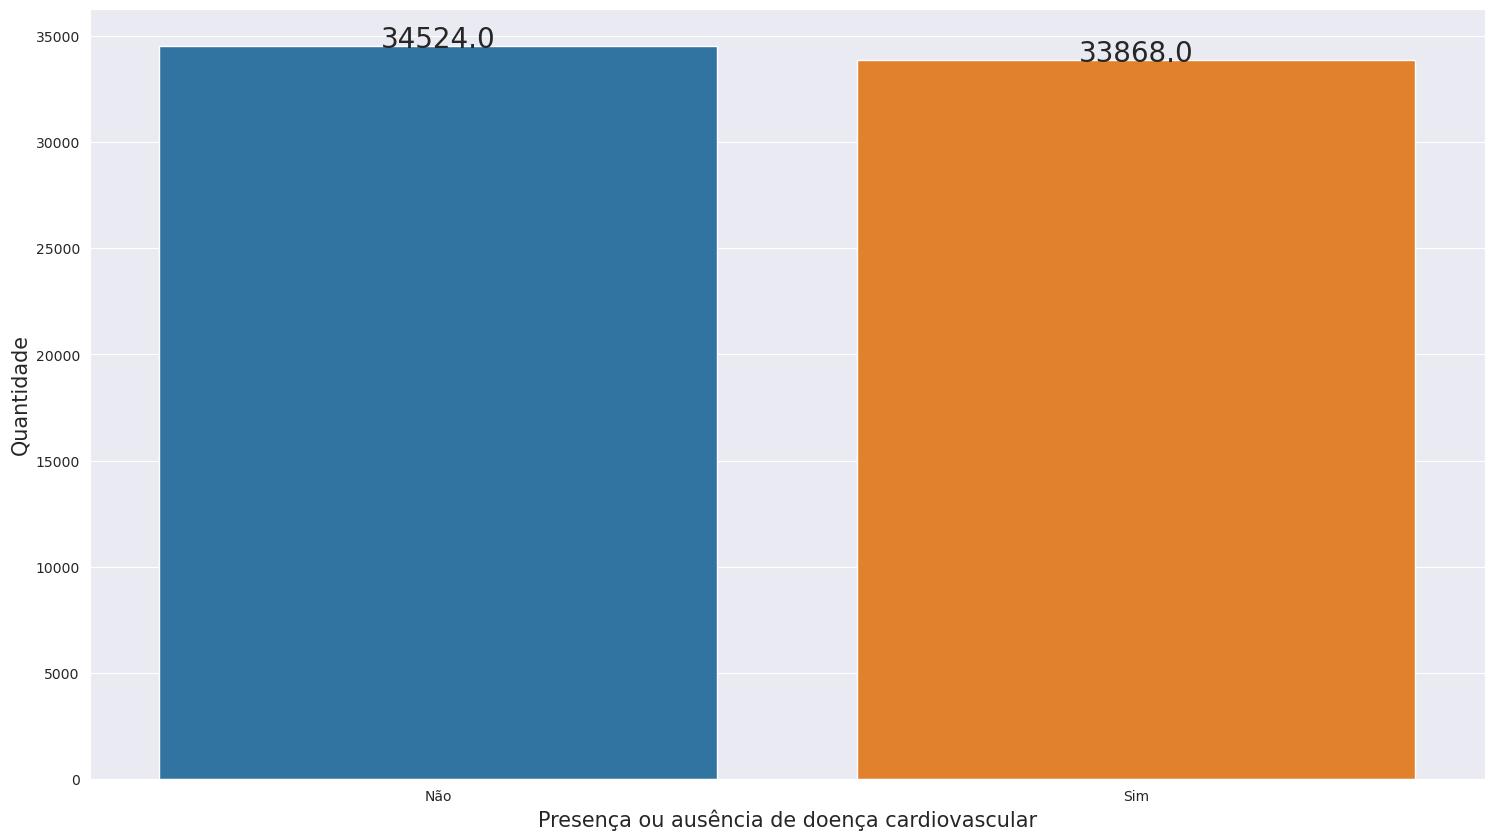

In [142]:
plt.figure(figsize=(18,10))
ax1 = sns.countplot(x=df4['presenca_ou_ausencia_de_doença_cardiovascular'])
data_load(ax1,'', 'Presença ou ausência de doença cardiovascular','Quantidade' )
plt.xticks(ticks=[0,1], labels=['Não','Sim'])

for p in ax1.patches:
    ax1.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',va='center', xytext=(0, 5), textcoords='offset points',fontsize=20)


plt.show()

### 6.1.2 Variável Numérica

Gráficos bem próximos da distribuição Gaussiana(Normal).

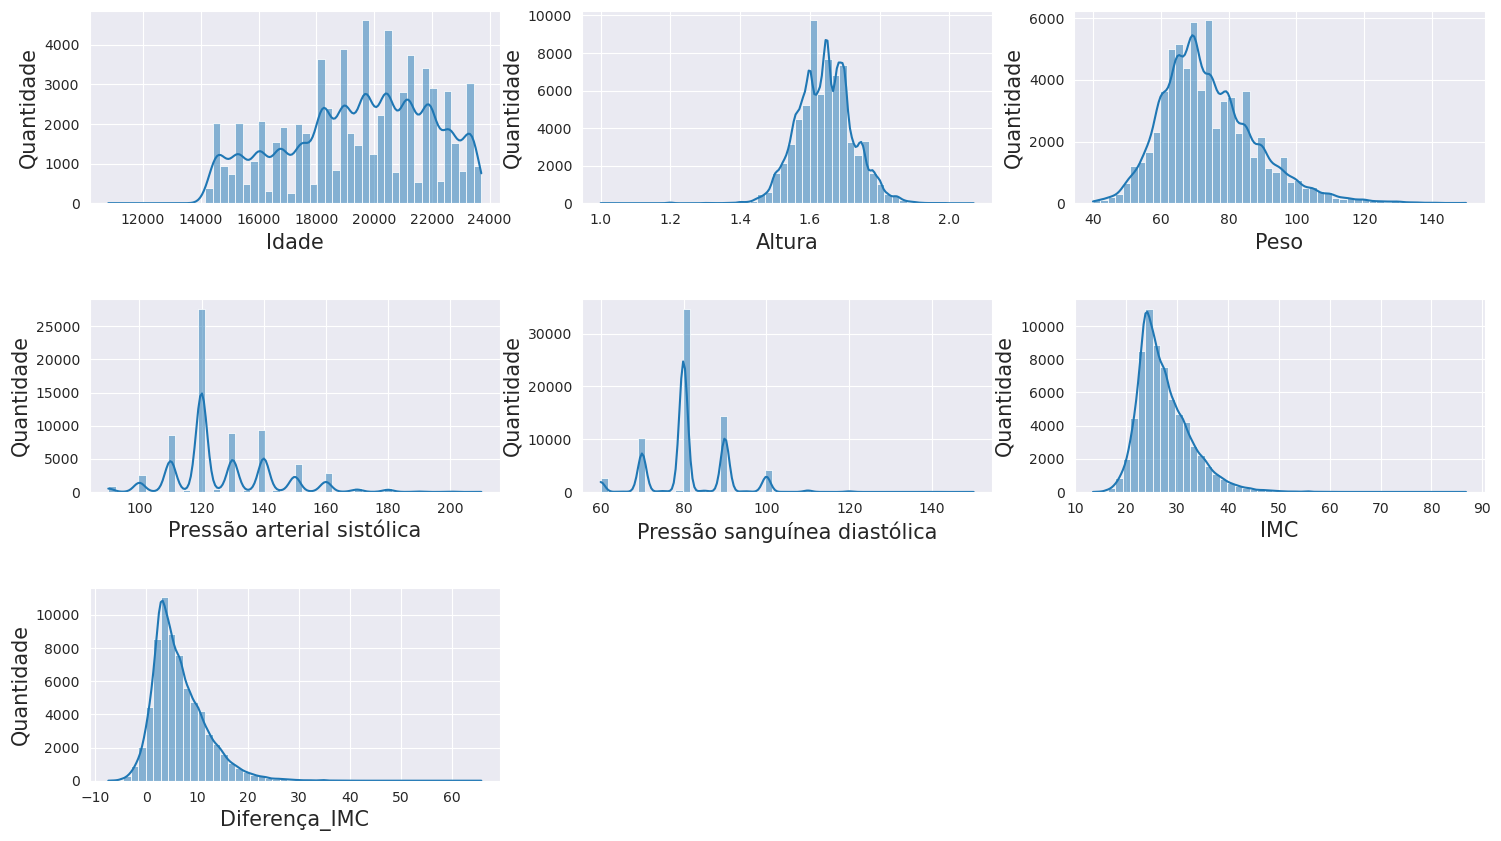

In [32]:
plt.figure(figsize=(18,10))

# Idade
plt.subplot(3,3,1)
ax1 = sns.histplot(x=df4['idade'],bins=50, kde=True)
data_load(ax1,'', 'Idade','Quantidade' )

# Altura
plt.subplot(3,3,2)
ax2 = sns.histplot(x=df4['altura'],bins=50, kde=True)
data_load(ax2,'','Altura','Quantidade' )

# Peso
plt.subplot(3,3,3)
ax3 = sns.histplot(x=df4['peso'],bins=50, kde=True)
data_load(ax3,'', 'Peso','Quantidade' )

# Pressão arterial sistólica
plt.subplot(3,3,4)
ax4 = sns.histplot(x=df4['pressao_arterial_sistolica'],bins=50, kde=True)
data_load(ax4,'', 'Pressão arterial sistólica','Quantidade' )

# Pressão sanguínea diastólica
plt.subplot(3,3,5)
ax5 = sns.histplot(x=df4['pressao_sanguinea_diastolica'],bins=50, kde=True)
data_load(ax5,'', 'Pressão sanguínea diastólica','Quantidade' )

# IMC
plt.subplot(3,3,6)
ax6 = sns.histplot(x=df4['IMC'],bins=50, kde=True)
data_load(ax6,'', 'IMC','Quantidade' )

# Diferença_IMC
plt.subplot(3,3,7)
ax7 = sns.histplot(x=df4['diferença_IMC'],bins=50, kde=True)
data_load(ax7,'', 'Diferença_IMC','Quantidade' )

plt.subplots_adjust(hspace=0.5)  
  
    
plt.show()

### 6.1.3 Variável Categórica

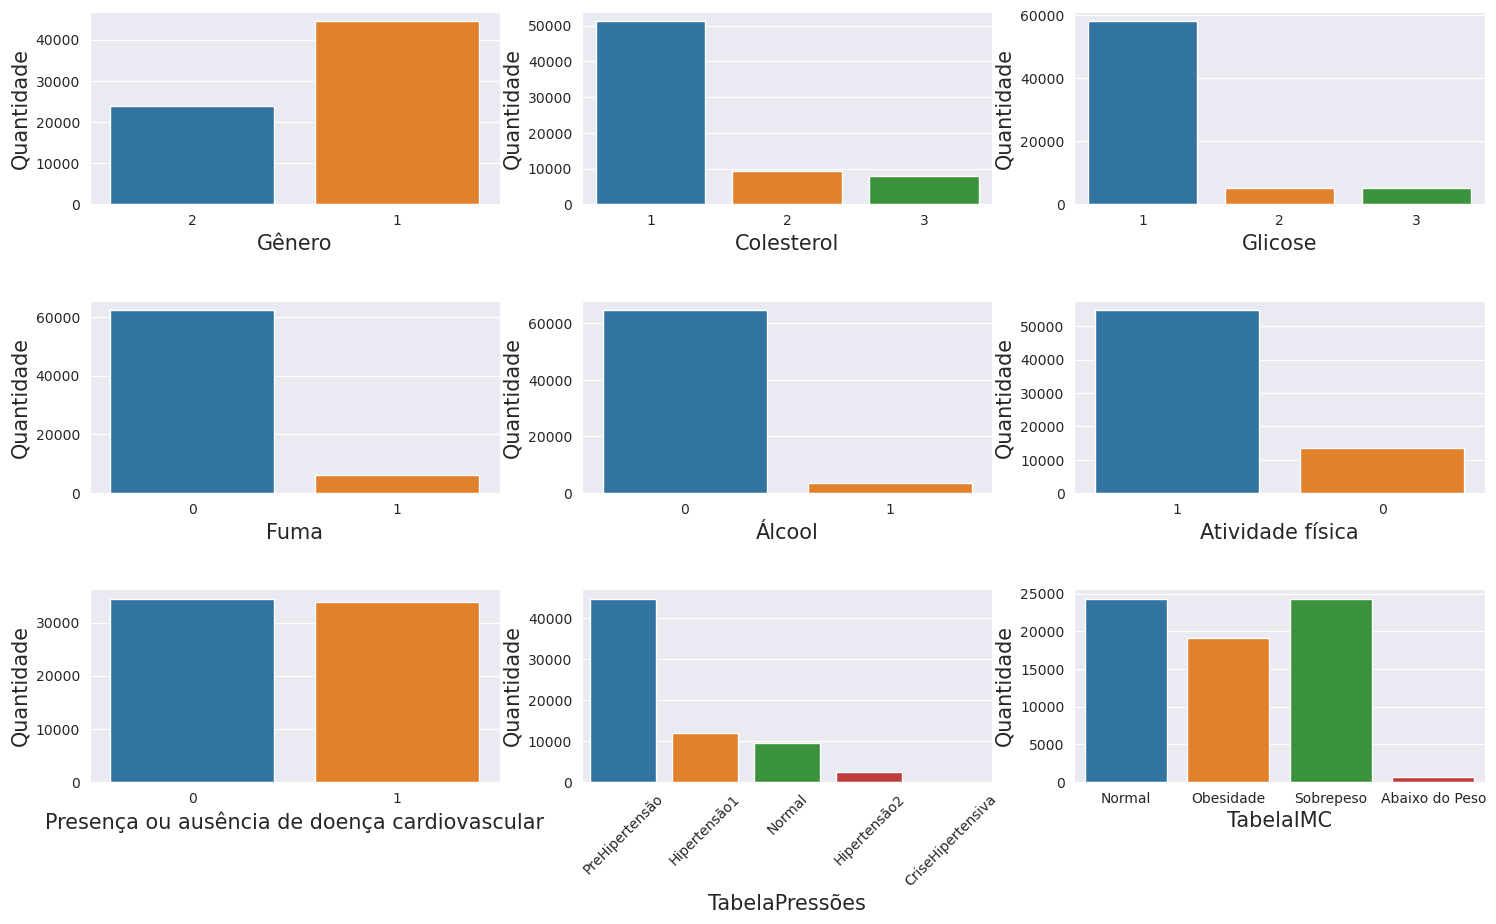

In [33]:
plt.figure(figsize=(18, 10))

# Gênero
plt.subplot(3,3,1)
ax1 = sns.countplot(x=df4['genero'])
data_load(ax1,'', 'Gênero','Quantidade' )

# Colesterol
plt.subplot(3,3,2)
ax2 = sns.countplot(x=df4['colesterol'])
data_load(ax2,'', 'Colesterol','Quantidade' )

# Glicose
plt.subplot(3,3,3)
ax3 = sns.countplot(x=df4['glicose'])
data_load(ax3,'', 'Glicose','Quantidade' )

# Fuma
plt.subplot(3,3,4)
ax4 = sns.countplot(x=df4['fuma'])
data_load(ax4,'', 'Fuma','Quantidade' )

# Álcool
plt.subplot(3,3,5)
ax5 = sns.countplot(x=df4['alcool'])
data_load(ax5,'', 'Álcool','Quantidade' )

# Atividade física
plt.subplot(3,3,6)
ax6 = sns.countplot(x=df4['atividade_fisica'])
data_load(ax6,' ', 'Atividade física','Quantidade' )

# Presença ou ausência de doença cardiovascular
plt.subplot(3,3,7)
ax7 = sns.countplot(x=df4['presenca_ou_ausencia_de_doença_cardiovascular'])
data_load(ax7,' ', 'Presença ou ausência de doença cardiovascular','Quantidade' )

# TabelaPressões
plt.subplot(3,3,8)
ax8 = sns.countplot(x=df4['tabela_pressoes'])
data_load(ax8,'', 'TabelaPressões','Quantidade' )

# TabelaIMC
plt.subplot(3,3,9)
ax9 = sns.countplot(x=df4['tabela_IMC'])
data_load(ax9,'', 'TabelaIMC','Quantidade' )

ax8.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5)
  
plt.show()    

## 6.2 Análises Bivariadas


## H1

Em cada classe de idade a maioria das pessoas não tem doença cardiovascular - **FALSO**

As pessoas com faixa etária acima de 56 anos começam a ser maioria com doença cardiovascular como observado nos 2 gráficos abaixo.

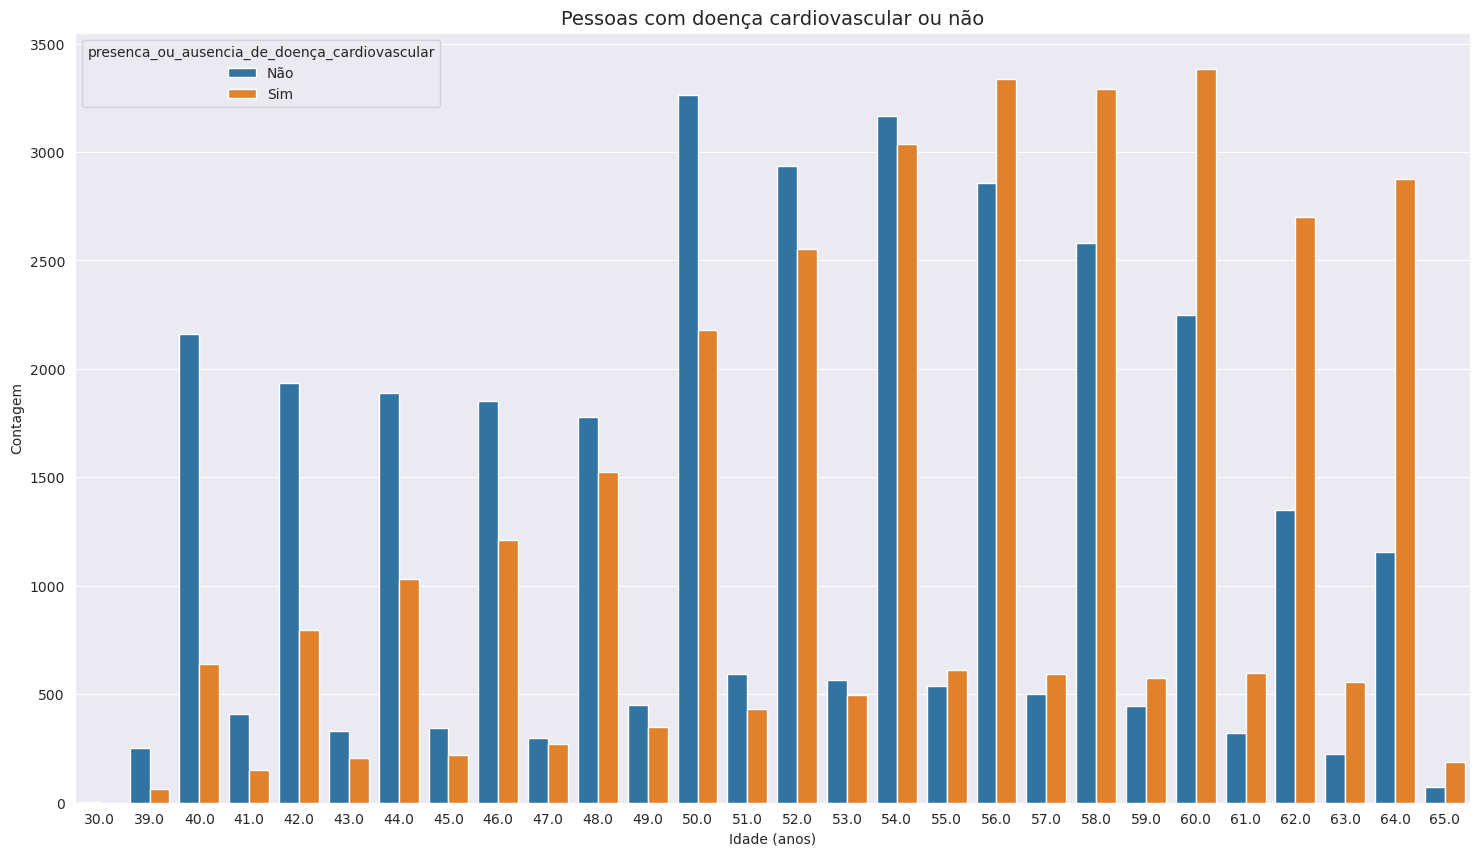

In [105]:
plt.figure(figsize=(18,10))

H1a = df4[['idade_2','presenca_ou_ausencia_de_doença_cardiovascular']].copy()
H1a = H1a.round(0)
H1a['presenca_ou_ausencia_de_doença_cardiovascular'] = H1a['presenca_ou_ausencia_de_doença_cardiovascular'].astype('int')
H1a['presenca_ou_ausencia_de_doença_cardiovascular'].replace([0, 1], ['Não','Sim'],inplace=True)

ax = sns.countplot(x='idade_2', hue='presenca_ou_ausencia_de_doença_cardiovascular', data=H1a)

plt.title("Pessoas com doença cardiovascular ou não", fontsize=14)
plt.xlabel("Idade (anos)")
plt.ylabel("Contagem")

plt.show()

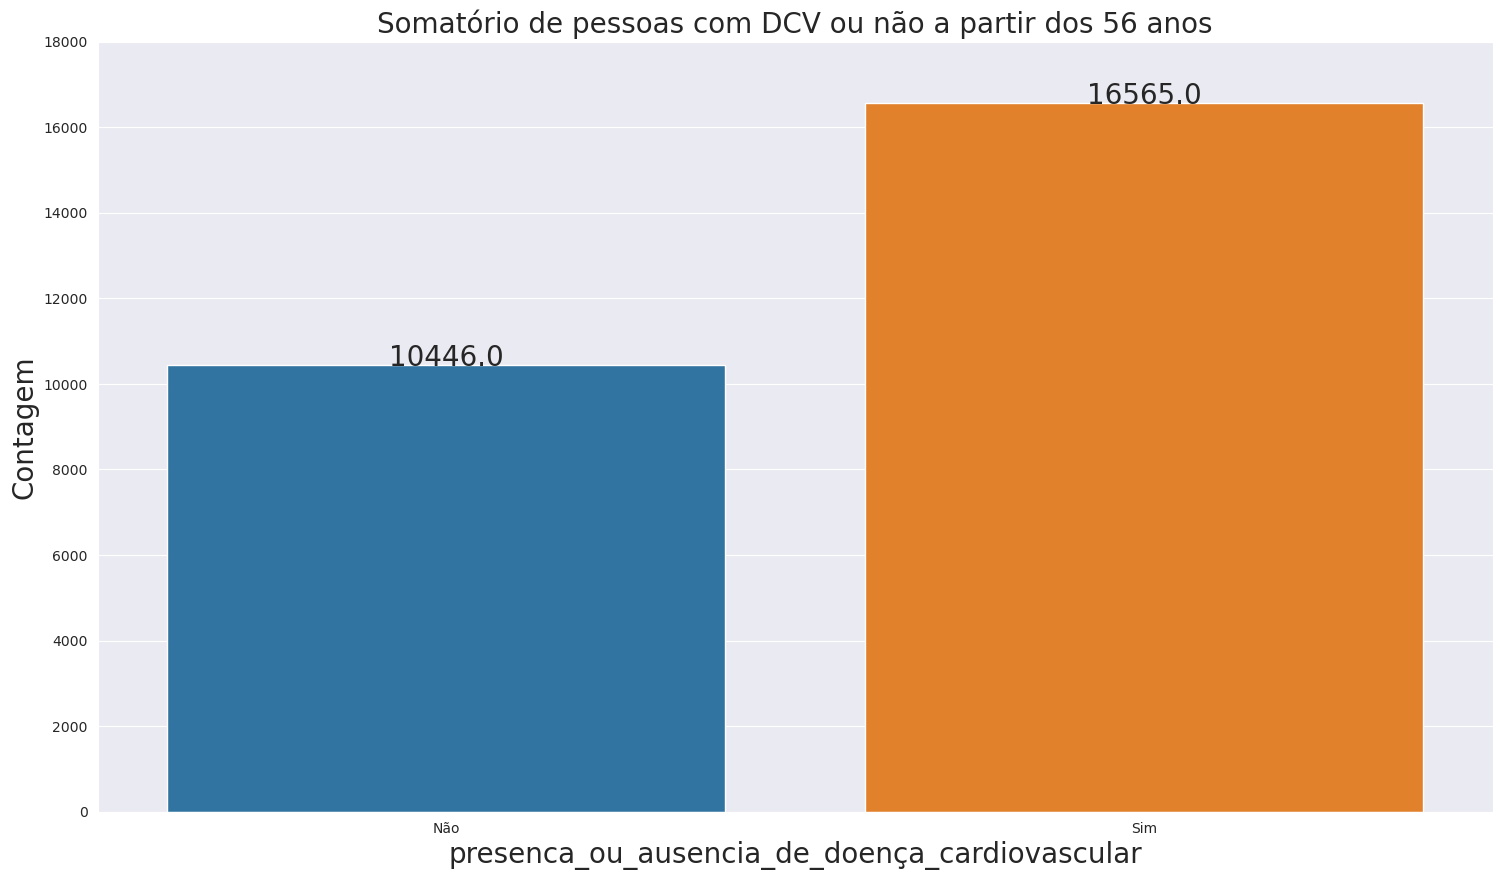

In [141]:
plt.figure(figsize=(18,10))

H1b = df4[df4['idade_2'] >= 56].copy()
H1bsn = H1b[['presenca_ou_ausencia_de_doença_cardiovascular','idade_2']].groupby('presenca_ou_ausencia_de_doença_cardiovascular').count().reset_index()
h1 = pd.merge(H1b,H1bsn, on='presenca_ou_ausencia_de_doença_cardiovascular')
h1.rename(columns={'idade_2_x': 'idade_2','idade_2_y': 'contagem'}, inplace=True)
h1['presenca_ou_ausencia_de_doença_cardiovascular'] = h1['presenca_ou_ausencia_de_doença_cardiovascular'].astype('int')
h1['presenca_ou_ausencia_de_doença_cardiovascular'].replace([0, 1], ['Não','Sim'],inplace=True)

ax1 = sns.barplot(x = 'presenca_ou_ausencia_de_doença_cardiovascular', y = 'contagem', data = h1)

plt.title("Somatório de pessoas com DCV ou não a partir dos 56 anos", fontsize=20)
plt.xlabel("presenca_ou_ausencia_de_doença_cardiovascular",fontsize=20)
plt.ylabel("Contagem",fontsize=20)

for p in ax1.patches:
    ax1.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',va='center', xytext=(0, 5), textcoords='offset points',fontsize=20)
max_y_lim = 18000
plt.ylim( 0, max_y_lim)

plt.show()

## H2
Pessoas que fumam tem mais chances de ter Doença Cardiovascular - **FALSO** 

Tanto pessoas que fumam, quanto pessoas que não fumam, tem chances de terem Doença Cardiovascular.

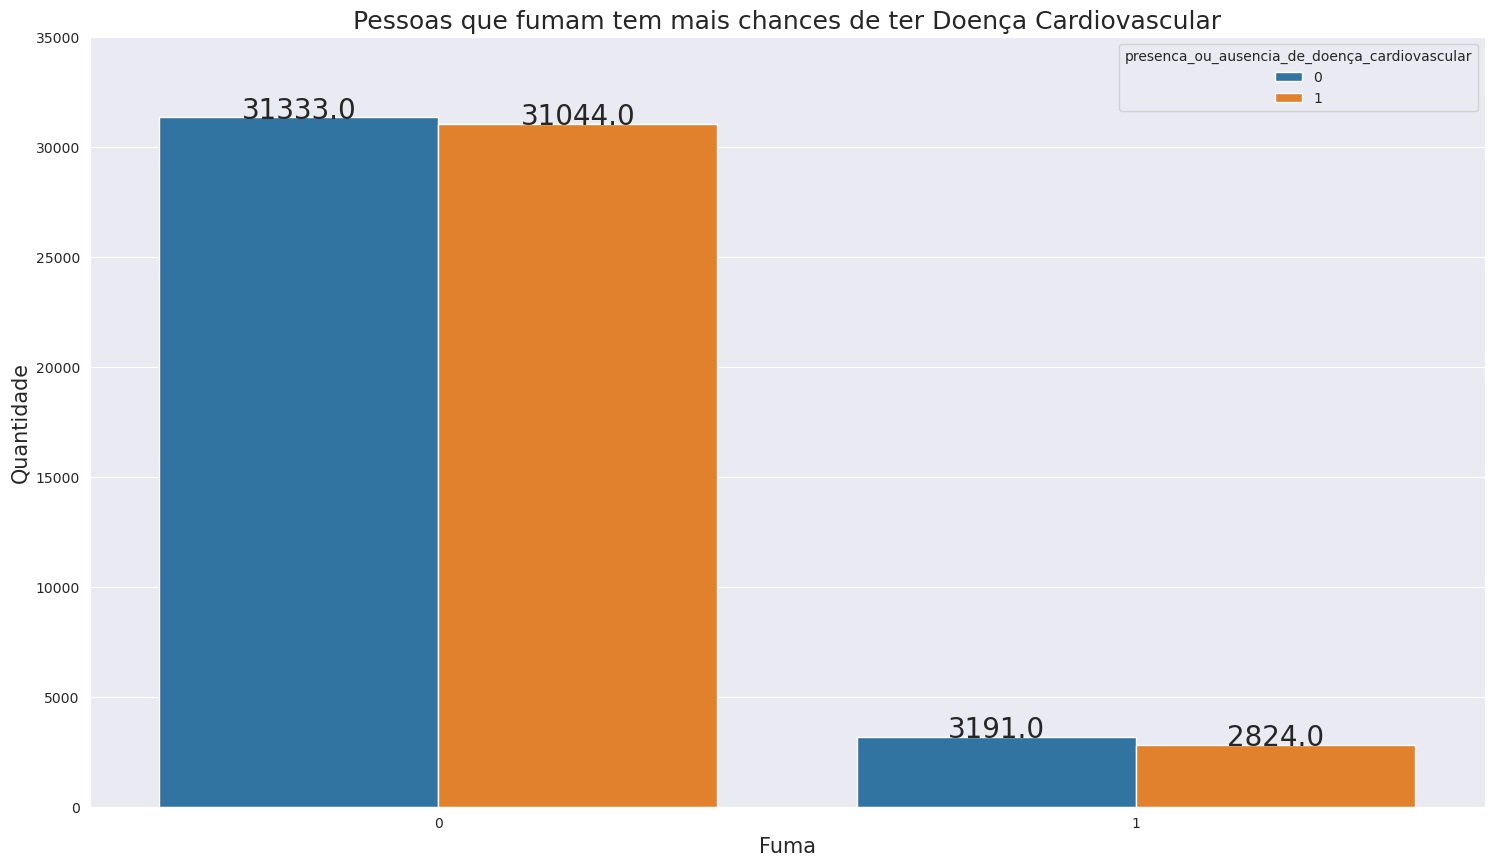

In [145]:
plt.figure(figsize=(18, 10))
plt.subplot(1,1,1)
ax1 = sns.countplot(x=df4['fuma'], hue=df4['presenca_ou_ausencia_de_doença_cardiovascular'])
data_load(ax1,'Pessoas que fumam tem mais chances de ter Doença Cardiovascular', 'Fuma','Quantidade' )

plt.subplots_adjust(hspace=0.5)

for p in ax1.patches:
    ax1.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',va='center', xytext=(0, 5), textcoords='offset points',fontsize=20)

max_y_lim = 35000
plt.ylim( 0, max_y_lim)
plt.show()

## H3
Mulheres tem mais chances de ter Doença Cardiovascular - **FALSO** 

De acordo com o gráfico, mulheres tem menos chance de ter Doença Cardiovascular que os homens.

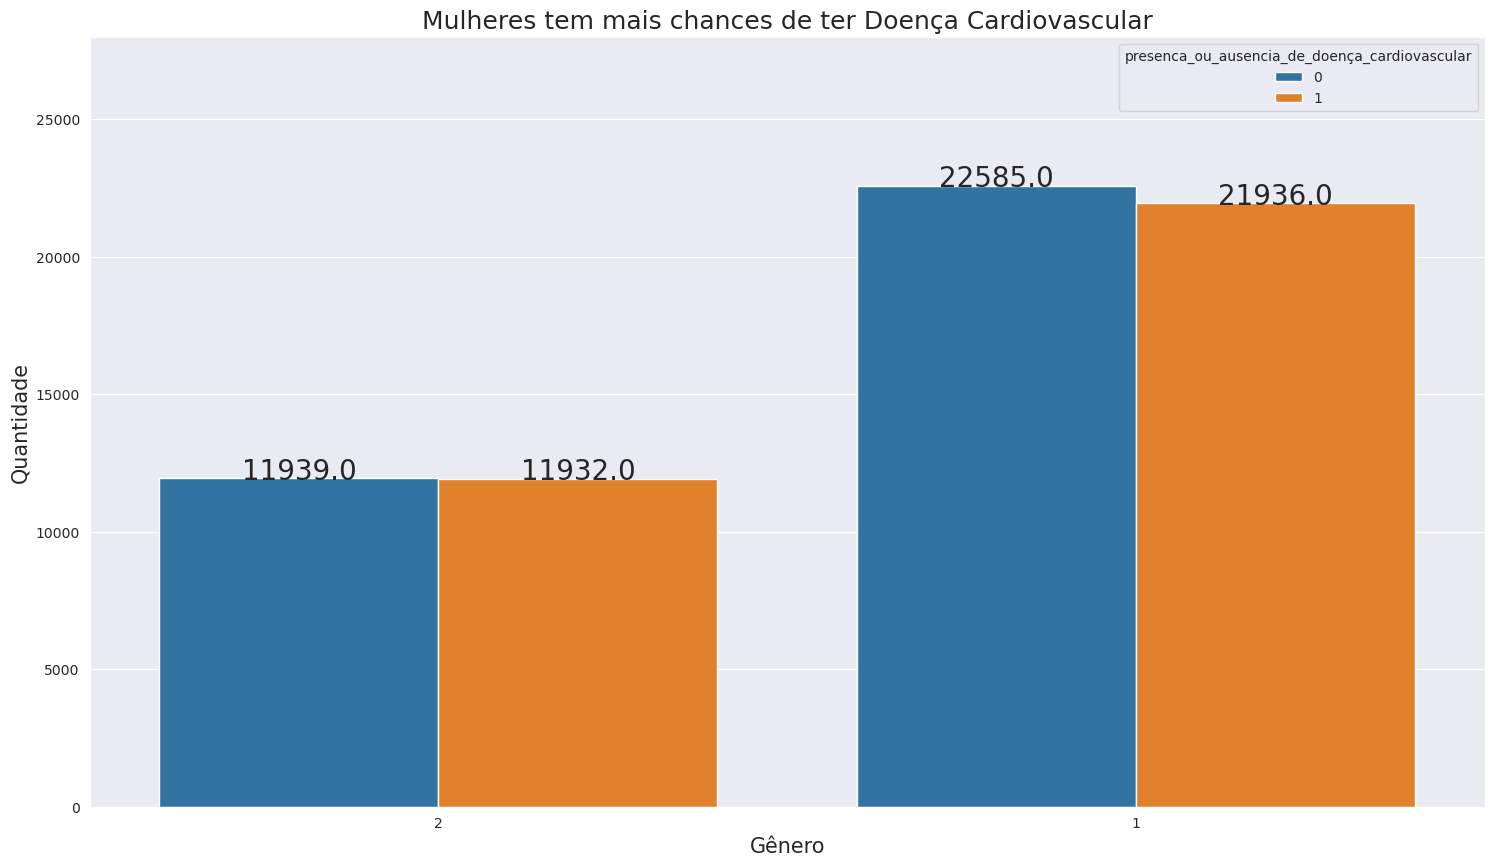

In [149]:
plt.figure(figsize=(18, 10))
plt.subplot(1,1,1)
ax2 = sns.countplot(x=df4['genero'], hue=df4['presenca_ou_ausencia_de_doença_cardiovascular'])
data_load(ax2,'Mulheres tem mais chances de ter Doença Cardiovascular', 'Gênero','Quantidade' )

plt.subplots_adjust(hspace=0.5)

for p in ax2.patches:
    ax2.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',va='center', xytext=(0, 5), textcoords='offset points',fontsize=20)
max_y_lim = 28000
plt.ylim( 0, max_y_lim)
plt.show()

## H4
Pessoas mais pesadas tem mais chances de ter Doença Cardiovascular - **VERDADEIRO**

Pessoas com Doença Cardiovascular possuem, em sua maioria, peso entre 65kg e 85kg, diferente dos que não tem, no qual possuem entre 62kg e 79kg.

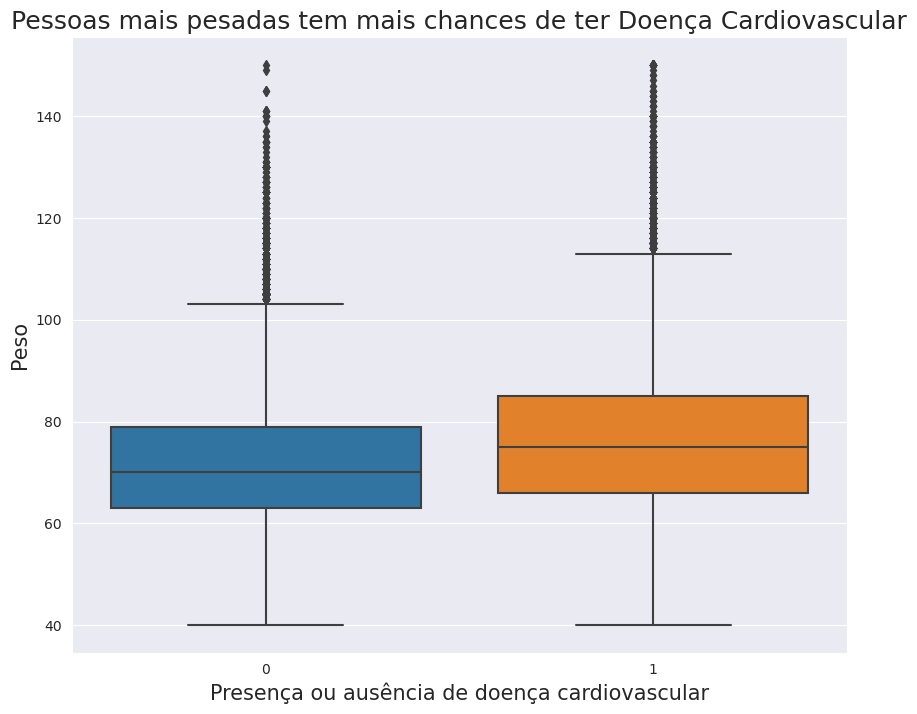

In [34]:
plt.figure(figsize=(10, 8))
plt.subplot(1,1,1)
ax3 = sns.boxplot(data = df4 , x="presenca_ou_ausencia_de_doença_cardiovascular", y="peso")
data_load(ax3,'Pessoas mais pesadas tem mais chances de ter Doença Cardiovascular', 'Presença ou ausência de doença cardiovascular','Peso' )

plt.subplots_adjust(hspace=0.5)

plt.show()

## H5
Pessoas que não fazem atividade física tem muito mais chances de ter Doença Cardiovascular - **FALSO**

De acordo com o gráfico, pessoas que não fazem atividade física tem mais chances de ter Doença Cardiovascular, mas não numa diferença grande.

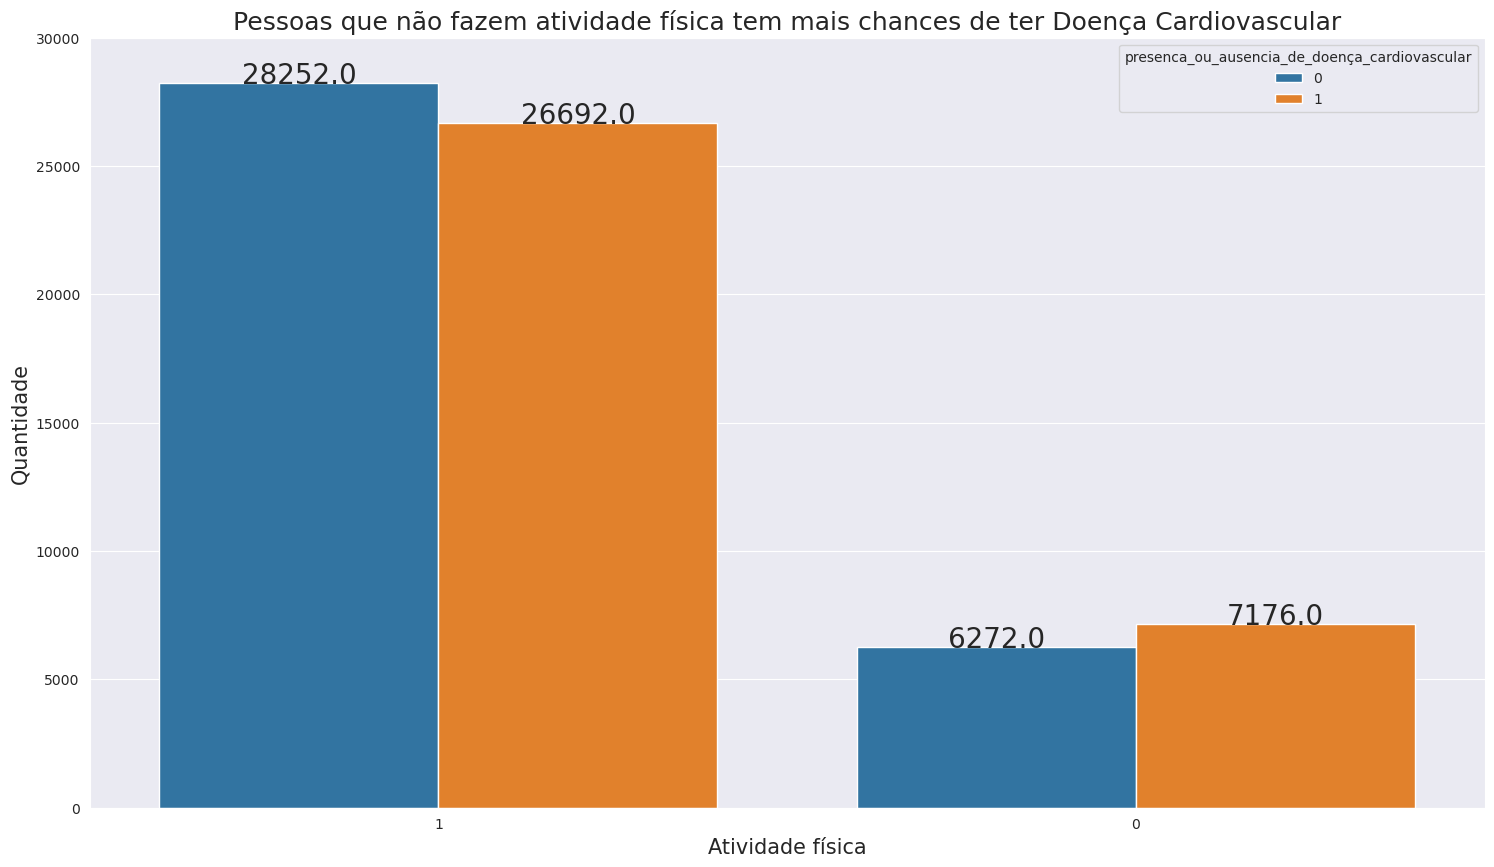

In [151]:
plt.figure(figsize=(18, 10))
plt.subplot(1,1,1)
ax4 = sns.countplot(x=df4['atividade_fisica'], hue=df4['presenca_ou_ausencia_de_doença_cardiovascular'])
data_load(ax4,'Pessoas que não fazem atividade física tem mais chances de ter Doença Cardiovascular', 'Atividade física','Quantidade' )

plt.subplots_adjust(hspace=0.5)

for p in ax4.patches:
    ax4.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',va='center', xytext=(0, 5), textcoords='offset points',fontsize=20)
max_y_lim = 30000
plt.ylim( 0, max_y_lim)

plt.show()

## H6
Pessoas que fumam e bebem simultaneamente tem mais chances de ter doença cardiovascular - **FALSO**

Pessoas que fumam e bebem simultaneamente tem menos quantidade populacional diagnosticada com Doença Cardiovascular.

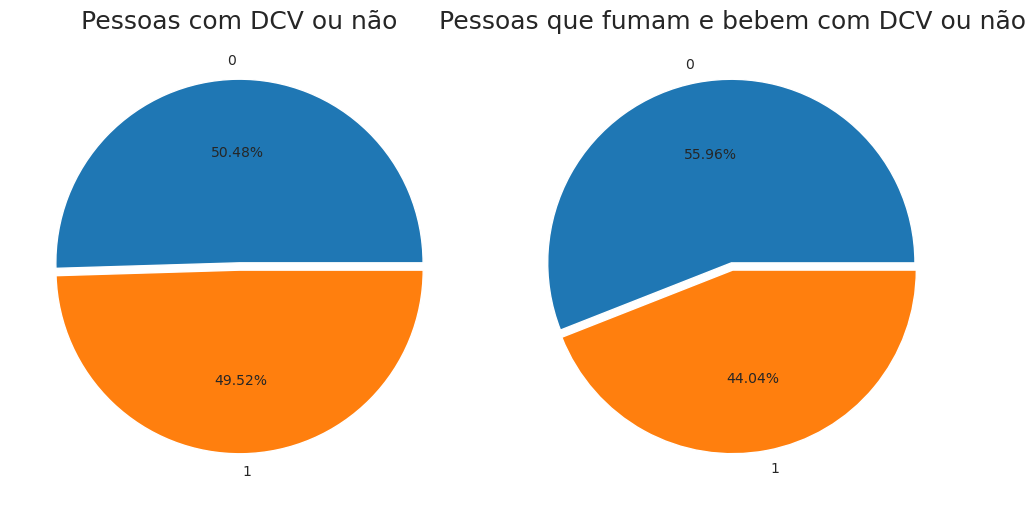

In [38]:
f, ax = plt.subplots(1,2, figsize=(10,5))
H5 = df4.loc[(df4['fuma'] == '1') & (df4['alcool'] == '1')]

df4['presenca_ou_ausencia_de_doença_cardiovascular'].value_counts().plot.pie(ax=ax[0], explode=[0.02, 0.02], autopct='%0.2f%%')

H5['presenca_ou_ausencia_de_doença_cardiovascular'].value_counts().plot.pie(ax=ax[1], explode=[0.02, 0.02], autopct='%0.2f%%')

data_load(ax[0],'Pessoas com DCV ou não', '','' )
data_load(ax[1],'Pessoas que fumam e bebem com DCV ou não', '','' )

plt.subplots_adjust(hspace=0.5)
f.tight_layout()
plt.show()

### 6.2.1 Visão Global das Hipóteses

In [130]:
tab =[['Hypothesis', 'Conclusion', 'Relevance', 'Discover'],
      ['H1', 'Falso', 'Alto', 'Em cada classe de idade a maioria das pessoas não tem doença cardiovascular .'],
      ['H2', 'Falso', 'Médio', 'Pessoas que fumam tem mais chances de ter Doença Cardiovascular.'],  
      ['H3', 'Falso', 'Médio', 'Mulheres tem mais chances de ter Doença Cardiovascular.'],  
      ['H4', 'Verdadeiro', 'Alto', 'Pessoas mais pesadas tem mais chances de ter Doença Cardiovascular.'],
      ['H5', 'Falso', 'Médio', 'Pessoas que não fazem atividade física tem muito mais chances de ter Doença Cardiovascular.'],
      ['H6', 'Falso', 'Alto', 'Pessoas que fumam e bebem simultaneamente tem mais chances de ter doença cardiovascular.']]
       

print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance    Discover
------------  ------------  -----------  -------------------------------------------------------------------------------------------
H1            Falso         Alto         Em cada classe de idade a maioria das pessoas não tem doença cardiovascular .
H2            Falso         Médio        Pessoas que fumam tem mais chances de ter Doença Cardiovascular.
H3            Falso         Médio        Mulheres tem mais chances de ter Doença Cardiovascular.
H4            Verdadeiro    Alto         Pessoas mais pesadas tem mais chances de ter Doença Cardiovascular.
H5            Falso         Médio        Pessoas que não fazem atividade física tem muito mais chances de ter Doença Cardiovascular.
H6            Falso         Alto         Pessoas que fumam e bebem simultaneamente tem mais chances de ter doença cardiovascular.


## 6.3 Análises Multivariadas

Vamos dividir os atributos em categóricos, numérico e binários para fazer correlações entre eles e excluir a ferramenta **Idade_2** por não ter mais utilidade.

### 6.3.1 Dtypes

Dados Numéricos:

* <code> idade <code> 
* <code> altura <code>
* <code> peso <code>
* <code> pressao_arterial_sistolica <code>
* <code> pressao_sanguinea_diastolica <code>
* <code> IMC <code>
* <code> diferença_IMC <code>

Dados Categóricos:

* <code> genero <code> 
* <code> colesterol <code>
* <code> glicose <code>
* <code> tabela_pressoes <code>
* <code> tabela_IMC <code>

Dados Binários:

* <code> fuma <code> 
* <code> alcool <code>
* <code> atividade_fisica <code>
    
    

In [40]:
# copiando o data set
df5 = df4.copy()

# salvar o data set 
df4.to_csv('data_saves/df4.csv', index=False)

# Removendo id e idade_2
df5 = df5.drop(['id', 'idade_2'], axis=1)
df5.head()

# Dividindo os dados em binary, numerical e categorical
categorical = df5[['genero','colesterol', 'glicose', 'tabela_pressoes', 'tabela_IMC']]
numerical = df5[['idade','altura', 'peso', 'pressao_arterial_sistolica', 'pressao_sanguinea_diastolica', 'IMC', 'diferença_IMC']]
binary = df5[['fuma','alcool', 'atividade_fisica']]

### 6.3.2 Atributos Categóricos

Usando o método estatístico do qui-quadrado, fizemos as correlações entre variáveis categóricas e colocamos num mapa de calor. Nesse mapa, a melhor correlação achada foi entre taxa de glicose e colesterol.

In [41]:
# Atribuindo variáveis para os dados categorical
a1 = categorical['genero']
a2 = categorical['colesterol']
a3 = categorical['glicose']
a4 = categorical['tabela_IMC']
a5 = categorical['tabela_pressoes']


# Correlação entre os dados categorical
x1 = UG.cramerv(a1, a1)
x2 = UG.cramerv(a1, a2)
x3 = UG.cramerv(a1, a3)
x4 = UG.cramerv(a1, a4)
x5 = UG.cramerv(a1, a5)

x6 = UG.cramerv(a2, a1)
x7 = UG.cramerv(a2, a2)
x8 = UG.cramerv(a2, a3)
x9 = UG.cramerv(a2, a4)
x10 = UG.cramerv(a2, a5)

x11 = UG.cramerv(a3, a1)
x12 = UG.cramerv(a3, a2)
x13 = UG.cramerv(a3, a3)
x14 = UG.cramerv(a3, a4)
x15 = UG.cramerv(a3, a5)

x16 = UG.cramerv(a4, a1)
x17 = UG.cramerv(a4, a2)
x18 = UG.cramerv(a4, a3)
x19 = UG.cramerv(a4, a4)
x20 = UG.cramerv(a4, a5)

x21 = UG.cramerv(a5, a1)
x22 = UG.cramerv(a5, a2)
x23 = UG.cramerv(a5, a3)
x24 = UG.cramerv(a5, a4)
x25 = UG.cramerv(a5, a5)

# DataFrame para armazenar os valores da correlação
data1_cramerv = pd.DataFrame({'genero': [x1, x2, x3, x4, x5],
                            'colesterol':[x6, x7, x8, x9, x10],
                            'glicose':[x11, x12, x13, x14, x15],
                            'tabela_IMC':[x16, x17, x18, x19, x20],
                            'tabela_pressoes  ':[x21, x22, x23, x24, x25]})

# colocar os índices igual as colunas
data1_cramerv = data1_cramerv.set_index(data1_cramerv.columns)
data1_cramerv

,genero,colesterol,glicose,tabela_IMC,tabela_pressoes
genero,0.999975,0.037348,0.021597,0.107947,0.080778
colesterol,0.037348,1.000015,0.392732,0.116524,0.127081
glicose,0.021597,0.392732,1.000015,0.088605,0.069156
tabela_IMC,0.107947,0.116524,0.088605,1.000022,0.128243
tabela_pressoes,0.080778,0.127081,0.069156,0.128243,1.000029


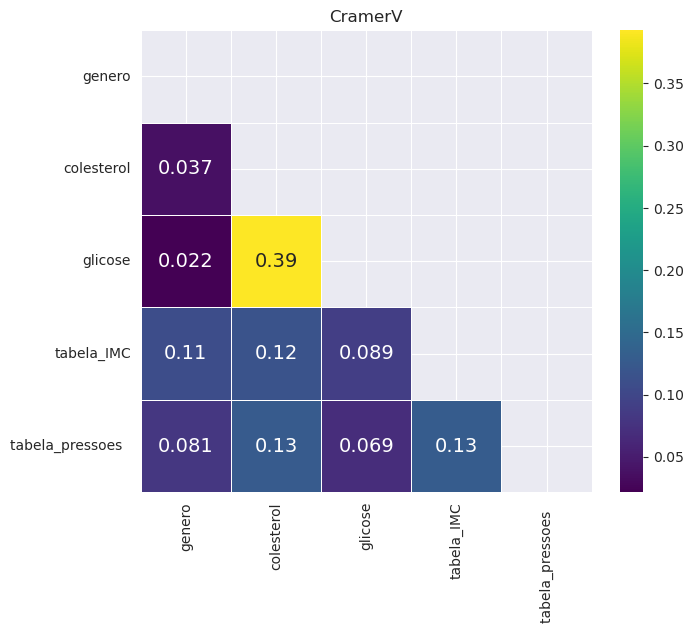

In [42]:
# Plotando a correlação
fig, ax = plt.subplots()

ax.figure.set_size_inches(16, 6)

plt.subplot(1,2,1)

TrueFalse = np.triu(np.ones_like(data1_cramerv, dtype=bool))
sns.heatmap(data1_cramerv, mask=TrueFalse, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("CramerV")

plt.show()

### 6.3.3 Atributos Numéricos

Nos atributos numéricos, usamos a correlação de Pearson num mapa de calor. Nesse mapa, observamos uma correlação maior entre elas.

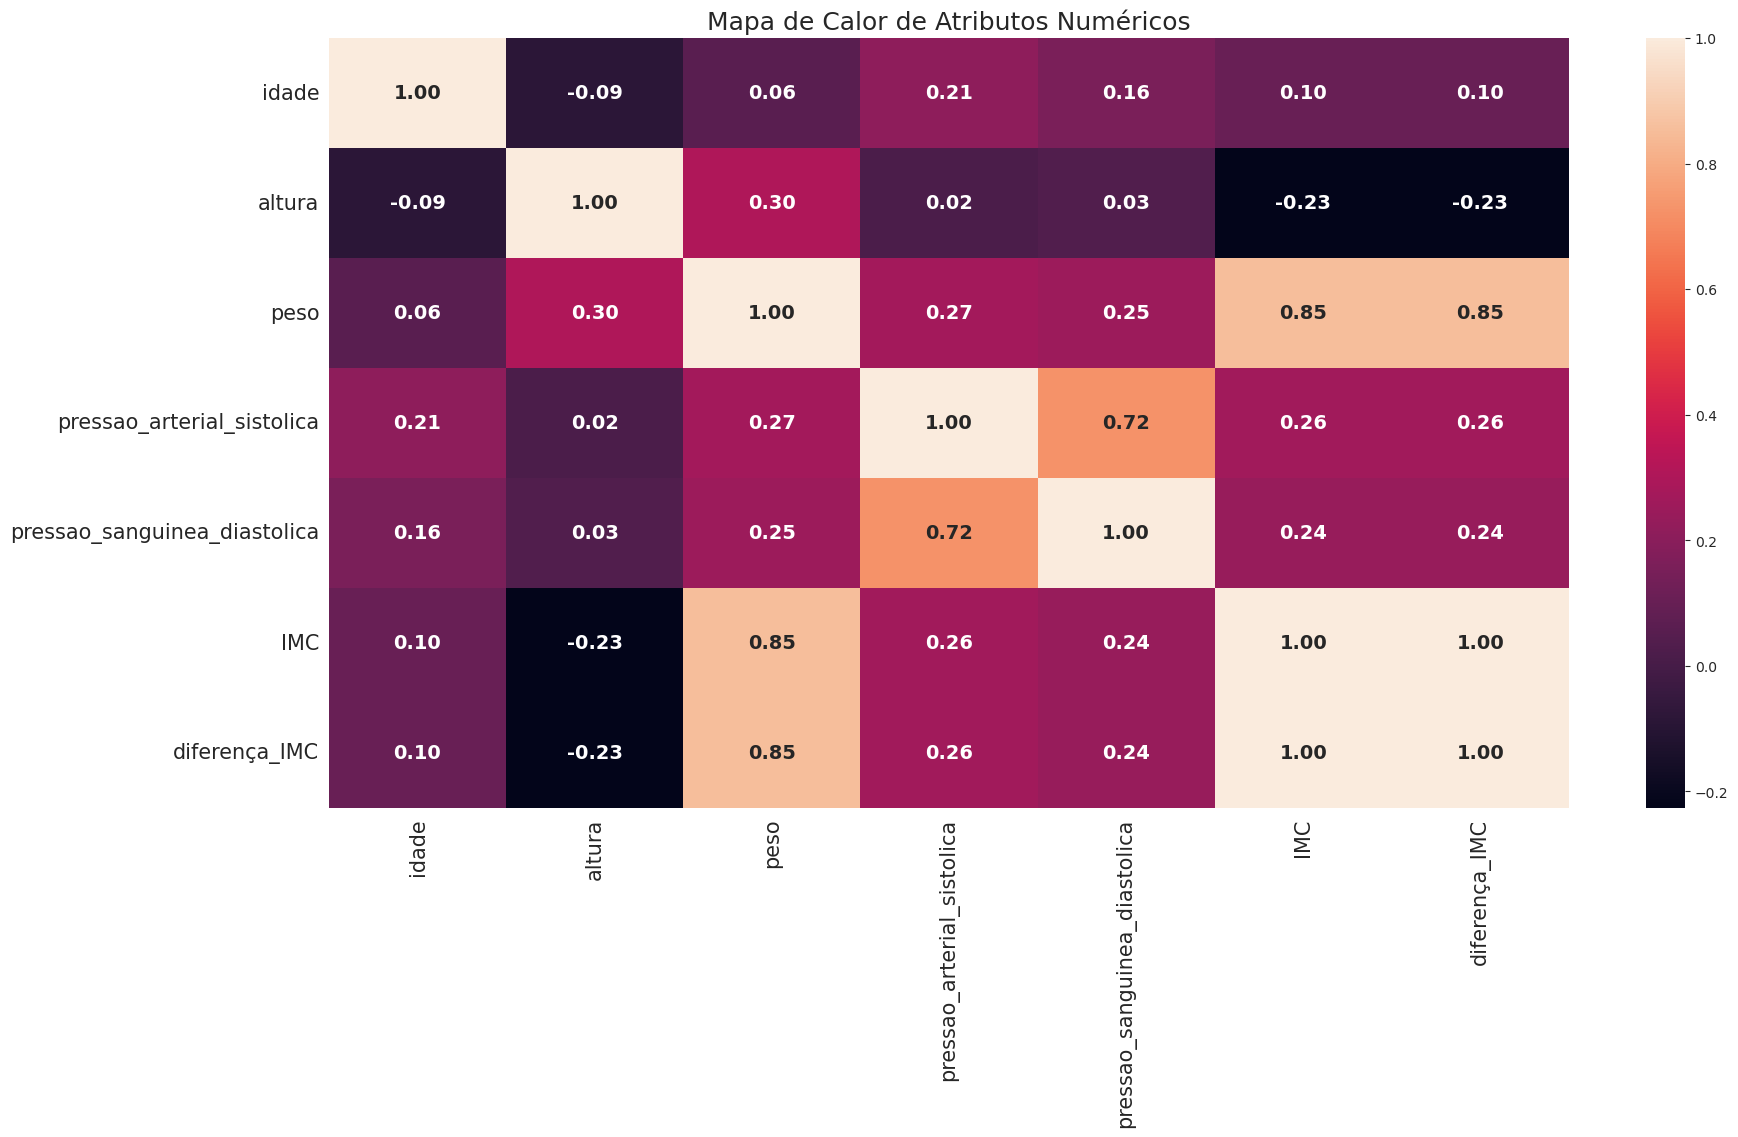

In [43]:
# Correlação entre dados int e float
NA = numerical.select_dtypes(['int64','int32', 'float64'])
correlation = NA.corr( method='pearson' )
plt.figure( figsize=(20, 10) )
ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':14, 'fontweight':'bold'})
ax1.set_xticklabels(correlation, fontsize=15)
ax1.set_yticklabels(correlation, fontsize=15)
data_load(ax1, 'Mapa de Calor de Atributos Numéricos', '', '')

### 6.3.4 Atributos Numéricos e Atributos Binários

Nos atributos abaixo, fizemos a correlação entre os dados binários e numéricos através do método do ponto-bisserial. De acordo com o mapa, as relações entre elas também deram um pouco baixas.

In [44]:
bi = binary.copy()
bi['fuma'] = bi['fuma'].astype('int')
bi['alcool'] = bi['alcool'].astype('int')
bi['atividade_fisica'] = bi['atividade_fisica'].astype('int')

In [45]:
a1 = numerical['idade']
a2 = numerical['altura']
a3 = numerical['peso']
a4 = numerical['pressao_arterial_sistolica']
a5 = numerical['pressao_sanguinea_diastolica']
a6 = numerical['IMC']
a7 = numerical['diferença_IMC']
a8 = bi['fuma']
a9 = bi['alcool']
a10 = bi['atividade_fisica']

# Correlação bisserial entre os dados numerical e binários
x1 = pointbiserialr(a8, a1)[0]
x2 = pointbiserialr(a8, a2)[0]
x3 = pointbiserialr(a8, a3)[0]
x4 = pointbiserialr(a8, a4)[0]
x5 = pointbiserialr(a8, a5)[0]
x6 = pointbiserialr(a8, a6)[0]
x7 = pointbiserialr(a8, a7)[0]
    
x8 = pointbiserialr(a9, a1)[0]
x9 = pointbiserialr(a9, a2)[0]
x10 = pointbiserialr(a9, a3)[0]
x11 = pointbiserialr(a9, a4)[0]
x12 = pointbiserialr(a9, a5)[0]
x13 = pointbiserialr(a9, a6)[0]
x14 = pointbiserialr(a9, a7)[0]
    

x15 = pointbiserialr(a10,a1)[0]
x16 = pointbiserialr(a10, a2)[0]
x17 = pointbiserialr(a10,a3)[0]
x18 = pointbiserialr(a10, a4)[0]
x19 = pointbiserialr(a10, a5)[0]
x20 = pointbiserialr(a10, a6)[0]
x21 = pointbiserialr(a10, a7)[0]    

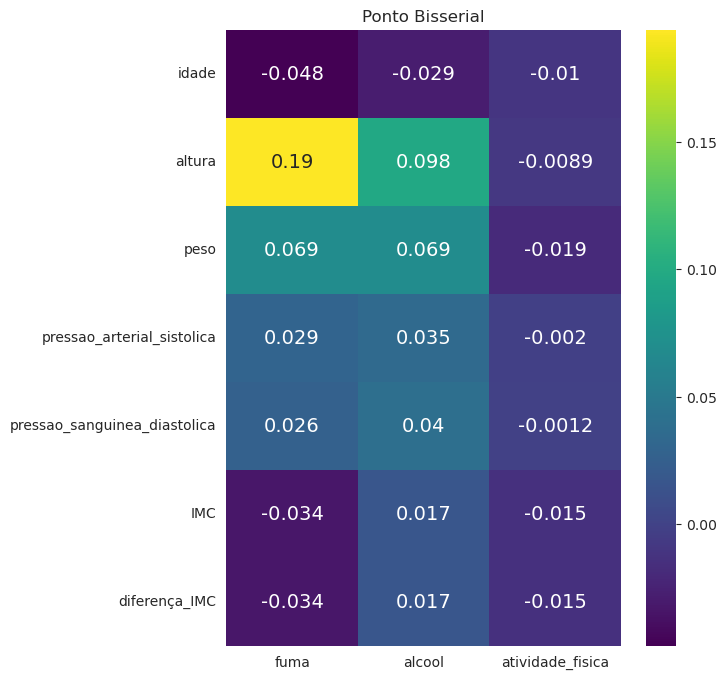

In [46]:
# Plotando a correlação
data1_pbs_r = pd.DataFrame({'fuma':[x1, x2, x3, x4, x5, x6, x7],
                         'alcool':[x8, x9, x10, x11, x12, x13, x14],
                         'atividade_fisica':[x15, x16, x17, x18, x19, x20, x21]})

data1_pbs_r = data1_pbs_r.set_index(numerical.columns)


fig, ax = plt.subplots()

ax.figure.set_size_inches(14, 8)

plt.subplot(1,2,1)
sns.heatmap(data1_pbs_r, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Ponto Bisserial")

plt.show()

# 7 Preparação dos Dados

* Reescalamos os dados numéricos para equilibrar os níveis de importâncias em relação à ferramentas com escalas mais baixas.
* Codificamos os dados binários ja que não existe nível de importância entre eles.
* Colocamos em quantidade de frequência em relaçao à quantidade total os dados categóricos.

In [47]:
# Carregar o data set
df6 = df5.copy()

# checar a dimensão do data set
df6.shape

(68392, 16)

## 7.1 treino e teste

In [48]:
# Dividindo em treino e teste
X = df6.drop(['presenca_ou_ausencia_de_doença_cardiovascular'], axis=1)
y = df6[['presenca_ou_ausencia_de_doença_cardiovascular']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

## 7.2 Reescalando

In [49]:
train_scale = X_train[['idade', 'altura', 'peso', 'pressao_arterial_sistolica', 'pressao_sanguinea_diastolica', 'IMC', 'diferença_IMC']]
test_scale = X_test[['idade', 'altura', 'peso', 'pressao_arterial_sistolica', 'pressao_sanguinea_diastolica', 'IMC', 'diferença_IMC']]

In [50]:
# Instanciando a normalização 
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_scale)

# Reescalando os dados numerical
train_numerical = mm_scaler.transform(train_scale.values)
test_numerical = mm_scaler.transform(test_scale.values)

In [51]:
train_numerical_scaled = pd.DataFrame(train_numerical, columns=train_scale.columns)
test_numerical_scaled = pd.DataFrame(test_numerical, columns=test_scale.columns)

In [52]:
pickle.dump(mm_scaler, open('model/numerical_scaler.pkl', 'wb'))

## 7.3 Transformação

In [53]:
# Selecionando a coluna Gênero
train_categorical = X_train[['genero']]
test_categorical = X_test[['genero']]

# Enumerando em ordem os índices
train_categorical.reset_index(drop=True, inplace=True)
test_categorical.reset_index(drop=True, inplace=True)

# Dividindo em valores binários 
train_cat_code = pd.get_dummies(train_categorical, drop_first=True)
test_cat_code = pd.get_dummies(test_categorical, drop_first=True)

In [54]:
# Selecionando as colunas binárias
train_binary = X_train[['fuma','alcool','atividade_fisica']]
test_binary = X_test[['fuma','alcool','atividade_fisica']]

# Enumerando em ordem os índices
train_binary = train_binary.reset_index(drop=True)
test_binary = test_binary.reset_index(drop=True)

### 7.3.1 Frequência de treino

Primeiro são os dados de treino a serem colocados em frequência.

In [55]:
# Selecionando as colunas categorical
train_cat_ = X_train[['colesterol','glicose','tabela_IMC','tabela_pressoes']]

# Enumerando em ordem os índices
train_cat_.reset_index(drop=True, inplace=True)

In [56]:
# Criado uma base de dados de frequência em relação ao total para Colesterol
cont_colesterol = train_cat_['colesterol'].value_counts().to_dict()
data1_colesterol = pd.DataFrame(cont_colesterol.items(), columns=['Valor','Contagem'])
data1_colesterol['frequencia'] = data1_colesterol['Contagem'] / data1_colesterol['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para Glicose
cont_glicose = train_cat_['glicose'].value_counts().to_dict()
data1_glicose = pd.DataFrame(cont_glicose.items(), columns=['Valor','Contagem'])
data1_glicose['frequencia'] = data1_glicose['Contagem'] / data1_glicose['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para TabelaIMC
cont_tabelaIMC = train_cat_['tabela_IMC'].value_counts().to_dict()
data1_tabelaIMC = pd.DataFrame(cont_tabelaIMC.items(), columns=['Valor','Contagem'])
data1_tabelaIMC['frequencia'] = data1_tabelaIMC['Contagem'] / data1_tabelaIMC['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para TabelaPressões 
cont_tabelapressões = train_cat_['tabela_pressoes'].value_counts().to_dict()
data1_tabelapressões = pd.DataFrame(cont_tabelapressões.items(), columns=['Valor','Contagem'])
data1_tabelapressões['frequencia'] = data1_tabelapressões['Contagem'] / data1_tabelapressões['Contagem'].sum()

In [57]:
# Transformando a base de dados de frequência criada em dicionário
freq_colesterol = data1_colesterol.set_index('Valor').to_dict()['frequencia']
freq_glicose = data1_glicose.set_index('Valor').to_dict()['frequencia']
freq_weight_status = data1_tabelaIMC.set_index('Valor').to_dict()['frequencia']
freq_tabelapressões = data1_tabelapressões.set_index('Valor').to_dict()['frequencia']

In [58]:
# Criando base de dados
train_cat_codificado = pd.DataFrame()

# Substituir os valores da base de dados real para as frequência obtidas
train_cat_codificado['colesterol'] =  train_cat_['colesterol'].map(freq_colesterol)
train_cat_codificado['glicose'] =  train_cat_['glicose'].map(freq_glicose)
train_cat_codificado['tabela_IMC'] =  train_cat_['tabela_IMC'].map(freq_weight_status)
train_cat_codificado['tabela_pressoes'] =  train_cat_['tabela_pressoes'].map(freq_tabelapressões)

### 7.3.2 Transformação de treino

In [59]:
# Concatenando os dados de transformação de treino
X_train_ = pd.concat([train_numerical_scaled, train_binary, train_cat_code, train_cat_codificado], axis=1)

### 7.3.3 Frequência de teste

Em seguida são colocados em frequência os dados de teste.

In [60]:
# Selecionando as colunas categorical
test_cat_ = X_test[['colesterol','glicose','tabela_IMC','tabela_pressoes']]

# Enumerando em ordem os índices
test_cat_.reset_index(drop=True, inplace=True)

In [61]:
# Criado uma base de dados de frequência em relação ao total para Colesterol
cont_colesterol = test_cat_['colesterol'].value_counts().to_dict()
data1_colesterol = pd.DataFrame(cont_colesterol.items(), columns=['Valor','Contagem'])
data1_colesterol['frequencia'] = data1_colesterol['Contagem'] / data1_colesterol['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para Glicose
cont_glicose = test_cat_['glicose'].value_counts().to_dict()
data1_glicose = pd.DataFrame(cont_glicose.items(), columns=['Valor','Contagem'])
data1_glicose['frequencia'] = data1_glicose['Contagem'] / data1_glicose['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para TabelaIMC
cont_tabelaIMC = test_cat_['tabela_IMC'].value_counts().to_dict()
data1_tabelaIMC = pd.DataFrame(cont_tabelaIMC.items(), columns=['Valor','Contagem'])
data1_tabelaIMC['frequencia'] = data1_tabelaIMC['Contagem'] / data1_tabelaIMC['Contagem'].sum()

# Criado uma base de dados de frequência em relação ao total para TabelaPressões
cont_tabelapressões = test_cat_['tabela_pressoes'].value_counts().to_dict()
data1_tabelapressões = pd.DataFrame(cont_tabelapressões.items(), columns=['Valor','Contagem'])
data1_tabelapressões['frequencia'] = data1_tabelapressões['Contagem'] / data1_tabelapressões['Contagem'].sum()

In [62]:
# Transformando a base de dados de frequência criada em dicionário
freq_colesterol = data1_colesterol.set_index('Valor').to_dict()['frequencia']
freq_glicose = data1_glicose.set_index('Valor').to_dict()['frequencia']
freq_weight_status = data1_tabelaIMC.set_index('Valor').to_dict()['frequencia']
freq_tabelapressões = data1_tabelapressões.set_index('Valor').to_dict()['frequencia']

In [63]:
# Criando base de dados
test_cat_codificado = pd.DataFrame()

# Substituir os valores da base de dados real para as frequência obtidas
test_cat_codificado['colesterol'] =  test_cat_['colesterol'].map(freq_colesterol)
test_cat_codificado['glicose'] =  test_cat_['glicose'].map(freq_glicose)
test_cat_codificado['tabela_IMC'] =  test_cat_['tabela_IMC'].map(freq_weight_status)
test_cat_codificado['tabela_pressoes'] =  test_cat_['tabela_pressoes'].map(freq_tabelapressões)

### 7.3.4 Transformação de teste

In [64]:
# Concatenando os dados de transformação de teste
X_test_ = pd.concat([test_numerical_scaled, test_binary, test_cat_code, test_cat_codificado], axis=1)

## 7.4 Checkpoint

In [65]:
X_train_.to_csv('data_saves/df6_train_.csv', index=False)
X_test_.to_csv('data_saves/df6_test_.csv', index=False)

In [68]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 8 Seleção de Recursos

Testamos para selecionar as melhores ferramentas o método do Boruta e o Extra Tree Classifier. O melhor resultado obtido foi pelo método Boruta, então o usamos.

## 8.1 Extra Tree Classifier

In [72]:
# Instanciando o ExtraTreesClassifier
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=43, n_jobs=-1)

# Treinando pelo ExtraTreesClassifier
forest.fit(X_train_, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=43)

Ranking de Ferramenta: 
                     Ferramenta  Importância
0                         idade     0.237400
0    pressao_arterial_sistolica     0.130373
0                           IMC     0.102164
0                 diferença_IMC     0.101903
0                          peso     0.097252
0                        altura     0.093930
0  pressao_sanguinea_diastolica     0.079430
0               tabela_pressoes     0.047309
0                    colesterol     0.042156
0                       glicose     0.014007
0                    tabela_IMC     0.013970
0                      genero_2     0.013963
0              atividade_fisica     0.011409
0                          fuma     0.007722
0                        alcool     0.007013


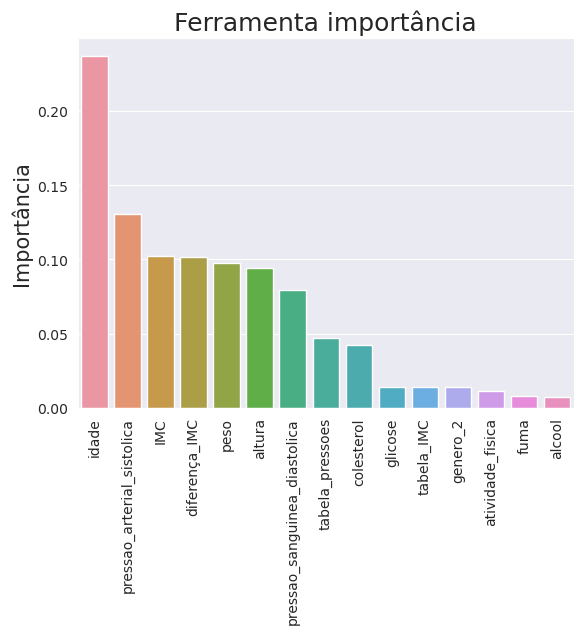

In [73]:
# a importância de cada feature de acordo com o modelo(média)
important_features = forest.feature_importances_

# Ranking das features
print('Ranking de Ferramenta: ')
ranking = pd.DataFrame()
for a, b in zip(X_train_, forest.feature_importances_):
    lista = pd.DataFrame({'Ferramenta': a, 'Importância': b}, index=[0])
    ranking = pd.concat([ranking,lista], axis=0)
    
print(ranking.sort_values('Importância', ascending=False))

# plotando os rankings das features
ax1 = sns.barplot(data=ranking.sort_values('Importância', ascending=False), x='Ferramenta', y='Importância' )
data_load(ax1, 'Ferramenta importância', '', 'Importância')
plt.xticks( rotation=90 );

In [74]:
# desvio padrão de cada importância de features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# ordem de maiores índices por importância de features do maior para o menor
indices = np.argsort(important_features)[::-1]

In [75]:
selecionar_colunas = list(ranking.sort_values('Importância', ascending=False)['Ferramenta'][:7])

x_train_et = X_train_[selecionar_colunas]
x_test_et = X_test_[selecionar_colunas]

## 8.2 Boruta Selecionado

In [76]:
# Instanciando ExtraTreesClassifier e RandomForestClassifier
RF_classifier = RandomForestClassifier(n_jobs=-1)
ET_classifier = ExtraTreesClassifier(n_jobs=-1)

In [77]:
X_train_ = X_train_.astype(float)
X_test_ = X_test_.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [78]:
# Definindo Boruta
boruta = BorutaPy(ET_classifier, n_estimators='auto', verbose=2, random_state=42).fit(X_train_.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration:

In [79]:
# Ranking das features
cols_selected = boruta.support_.tolist()
cols_selected_boruta =X_train_.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['idade',
 'peso',
 'pressao_arterial_sistolica',
 'pressao_sanguinea_diastolica',
 'IMC',
 'diferença_IMC',
 'tabela_pressoes']

In [80]:
X_train_boruta = X_train_[cols_selected_boruta].copy()
X_test_boruta = X_test_[cols_selected_boruta].copy()

<Axes: >

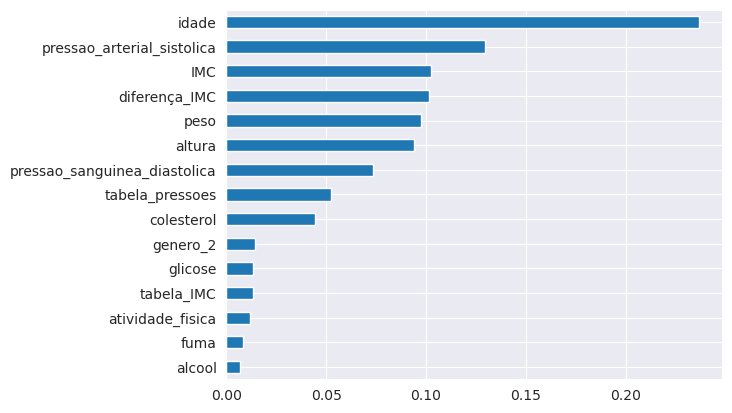

In [81]:
# Plotando o ranking das features
ET_classifier.fit(X_train_, y_train)

feat_importances = pd.Series(ET_classifier.feature_importances_, index=X_train_.columns)
feat_importances.sort_values().plot(kind='barh')

# 9 Machine Learning

#### 0 = Não possui Doença Cardiovascular
#### 1 = Possui Doença Cardiovascular

## 9.1 Classificadores

Usamos vários modelos de Machine Learning e o algoritmo que melhor atende as necessidades dos pacientes de forma rápida e com uma precisão melhor é o **LGBMClassifier**, pois possui melhor acurácia do F1-Score que é o que procuramos, assim como uma porcentagem baixa de falsos negativos que é bastante importante para quem é paciente dessa empresa.

In [84]:
# Definir o threshold
THRESHOLD = 0.45

# Definir os classifiers
classifiers = [LogisticRegression(max_iter=220, random_state=42),
               RandomForestClassifier(random_state=42),
               xgb.XGBClassifier(random_state=42),
               CatBoostClassifier(random_state=42, verbose=False),
               KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
               SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1), 
               LGBMClassifier(deterministic=True,force_row_wise=True,random_state=42, n_jobs=-1, verbose=-1), 
               GaussianNB()]

# Calcular as performances dos classifiers 
performance_dados = UG.performance_modelo(X_train_boruta, X_test_boruta, 
                                                y_train, y_test, 
                                                THRESHOLD, classifiers)

Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training CatBoostClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training LGBMClassifier...
Training GaussianNB...


In [85]:
# Valores máximos de cada coluna
performance_dados.style.highlight_max(color='darkorange')

,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.705042,0.702014,0.703525,0.774557,0.707946,0.415766
2,RandomForestClassifier,0.652401,0.704384,0.677396,0.727362,0.668835,0.338229
4,XGBClassifier,0.703818,0.707050,0.705430,0.773560,0.708531,0.417001
6,CatBoostClassifier,0.704415,0.711197,0.707790,0.777385,0.710140,0.420255
8,KNeighborsClassifier,0.648114,0.684686,0.665898,0.712893,0.660867,0.322106
10,SGDClassifier,0.643123,0.818572,0.720318,0.774439,0.686234,0.374521
12,LGBMClassifier,0.709615,0.710456,0.710036,0.780230,0.713576,0.427066
14,GaussianNB,0.732018,0.587826,0.652045,0.755095,0.690328,0.379010


## 9.2 ROC AUC

Feito o gráfico da curva ROC, observamos como o modelo **LGBMClassifier** é bom comparado à reta sem habilidade.

In [86]:
# Instanciando LGBMClassifier
LGBMClassifier = LGBMClassifier(deterministic=True,force_row_wise=True,random_state=42, n_jobs=-1,verbose=-1)

# Treinando LGBMClassifier
LGBMClassifier.fit(X_train_boruta, np.ravel(y_train))

# Calculando as probabilidades de predição
y_pred_rf_prob = LGBMClassifier.predict_proba(X_test_boruta)[:,1]

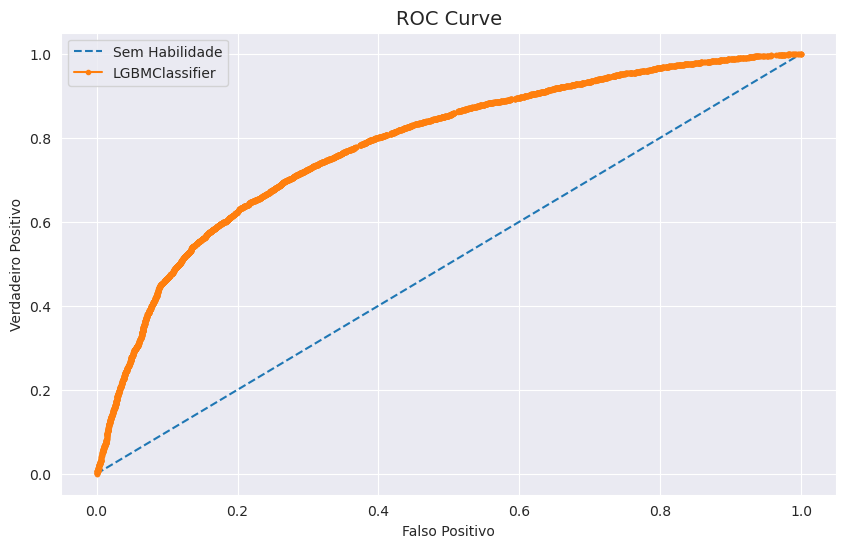

In [87]:
# Plotando a curva ROC AUC
fig, ax = plt.subplots()

ax.figure.set_size_inches(10, 6)

ns_probs = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_rf_prob)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sem Habilidade')
plt.plot(rf_fpr, rf_tpr, marker='.', label='LGBMClassifier')

plt.title("ROC Curve", fontsize=14)
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')

plt.legend()

plt.show()

In [88]:
pickle.dump(LGBMClassifier, open('model/LGBMClassifier.pkl', 'wb'))

## 9.3 Matriz de Confusão

Como podemos observar, na matriz de confusão(confusion matriz), o modelo **LGBMClassifier** é o que possui maior equilíbrio entre falsos positivos e falsos negativos, por isso escolhemos esse modelo.

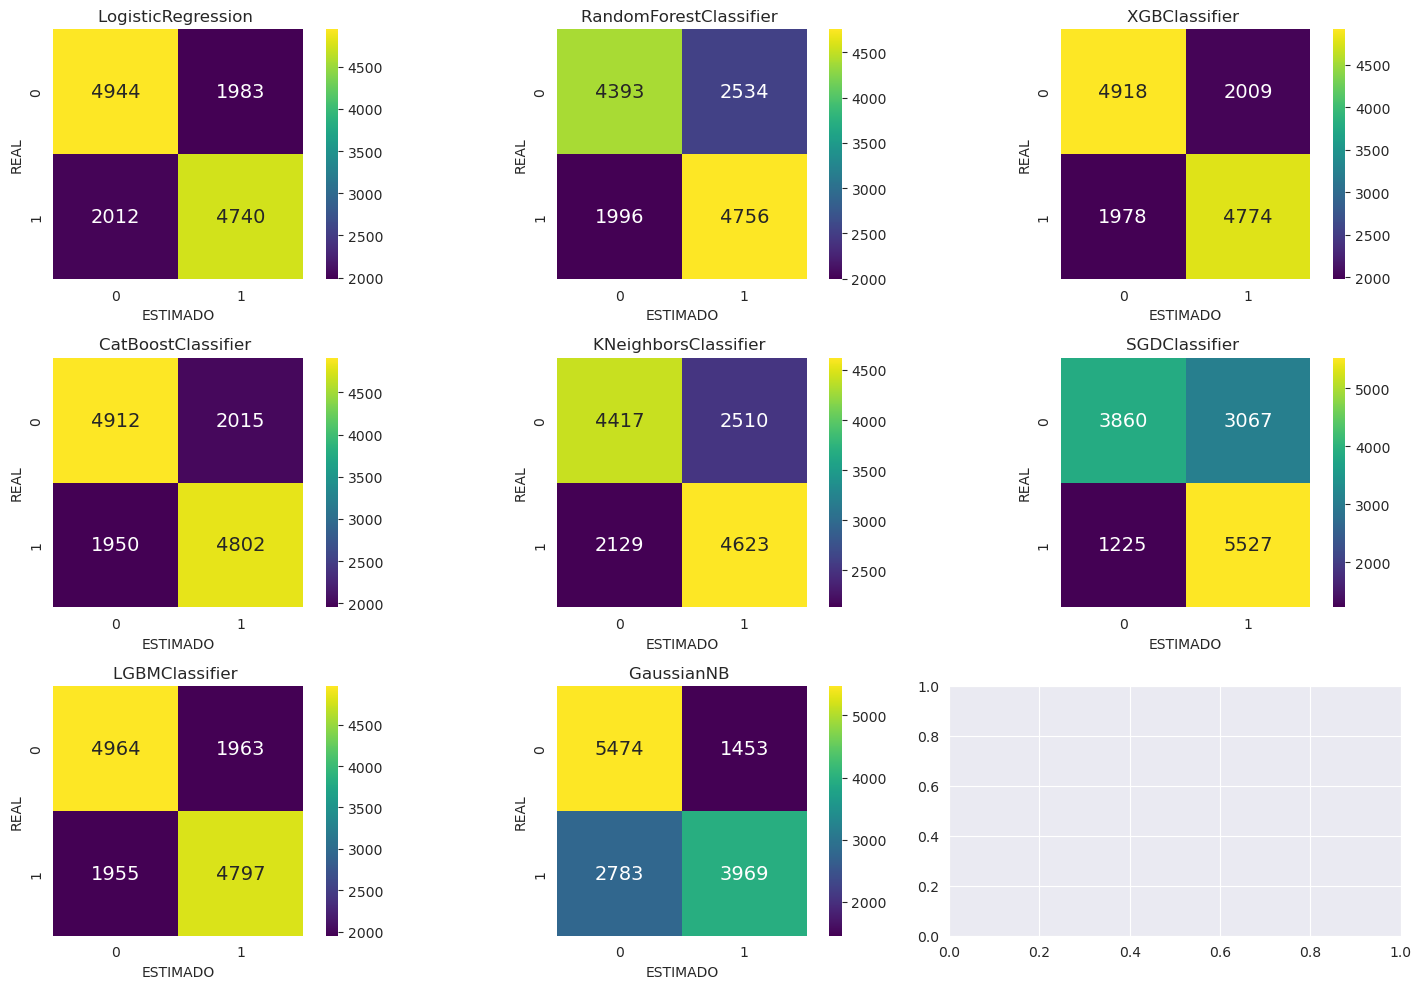

In [89]:
# Selecionar as dimensões das subplots
n_rows = 3
n_cols = 3
threshold = 0.45
model = classifiers
qualifier=""

# Plotando matriz de confusão
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

for clf, ax, n in zip(classifiers, ax.flatten(), list(range(n_rows*n_cols))):
    clf_probs = clf.predict_proba(X_test_boruta)

    probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_positivo'])

    y_pred = probs['prob_positivo'].apply(
        lambda x: 1 if x > threshold else 0)

    plt.subplot(n_rows, n_cols, n+1)
    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
                    square=True, annot_kws={"size": 14})

    plt.xlabel("ESTIMADO")
    plt.ylabel("REAL")
    ax.title.set_text(type(clf).__name__ + ' ' + str(qualifier))

plt.tight_layout()

plt.show()               

# 9.4 Validação-Cruzada


Usamos a Validação-Cruzada(**Cross-Validation**) no LGBMClassifier para tentar melhorar nosso modelo.

In [90]:
# Concatenando dados de teste e treino pelo método Boruta
X_all = pd.concat([X_train_boruta, X_test_boruta], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [91]:
LGBMClassifier = pickle.load(open('model/LGBMClassifier.pkl', 'rb'))

In [92]:
# Instanciando o StratifiedKFold para Cross-validation
cv = StratifiedKFold(n_splits=10)

In [93]:
# Calculando acurácia de precision
cv_scores = cross_val_score(LGBMClassifier, X_all, y_all, cv=cv, scoring='precision', n_jobs=1)
print("Average precision : %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))
print()

# Calculando acurácia de recall
cv_scores1 = cross_val_score(LGBMClassifier, X_all, y_all, cv=cv, scoring='recall', n_jobs=1)
print("Average recall : %0.4f (+/- %0.4f)" % (cv_scores1.mean(), cv_scores1.std() * 2))
print()

# Calculando acurácia de f1-score
cv_score2 = cross_val_score(LGBMClassifier, X_all, y_all, cv=cv, scoring='f1', n_jobs=1)
print("Average f1-score : %0.4f (+/- %0.4f)" % (cv_score2.mean(), cv_score2.std() * 2))
print()

# Calculando acurácia de roc_auc
cv_score3 = cross_val_score(LGBMClassifier, X_all, y_all, cv=cv, scoring='roc_auc', n_jobs=1)
print("Average roc_auc : %0.4f (+/- %0.4f)" % (cv_score3.mean(), cv_score3.std() * 2))
print()


Average precision : 0.7401 (+/- 0.0201)

Average recall : 0.6797 (+/- 0.0182)

Average f1-score : 0.7085 (+/- 0.0134)

Average roc_auc : 0.7886 (+/- 0.0133)



# 10 Hiperparâmetros

Através dos hiperparâmetros vamos encontrar o desvio padrão de cada acurácia e aplicar no modelo.

In [94]:
LGBMClassifier = pickle.load(open('model/LGBMClassifier.pkl', 'rb'))

In [97]:
# Configurar com hiperparâmetros especificados
space = {'max_depth': np.arange(2, 12, 2), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

# Preparar para treinar o RandomizedSearchCV
LGBM_ = RandomizedSearchCV(estimator=LGBMClassifier, param_distributions=space,
                                scoring='f1', n_iter=100, cv=5, verbose=1,
                                random_state=42, n_jobs=-1)

In [98]:
# Treinar os dados pelo RandomizedSearchCV
LGBM_.fit(X_train_boruta.values,np.ravel(y_train.values))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(deterministic=True,
                                            force_row_wise=True, n_jobs=-1,
                                            random_state=42, verbose=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'subsample': array([0.25      , 0.30357143, 0.35714286, 0.41071429, 0.46428571,
       0.51785714, 0.57142857, 0.625     , 0.67857143, 0.73214286,
       0.78571429, 0.83928571, 0.89285714, 0.94642857, 1.        ])},
                   random_state=42, scoring='f1', verbose=1)

In [99]:
# Calcular o melhor estimator para Modelo Final
LGBM_.best_estimator_

LGBMClassifier(deterministic=True, force_row_wise=True,
               learning_rate=0.5144285714285713, max_depth=2, n_estimators=25,
               n_jobs=-1, random_state=42, subsample=0.4642857142857143,
               verbose=-1)

In [105]:
pickle.dump(LGBM_.best_estimator_, open('model/LGBM_.best_model.pkl', 'wb'))

## 10.1 Modelo Final

Por fim, vamos aplicar o modelo final de acordo com os dados do hiperparâmetro com o objetivo de obter o melhor resultado junto à melhor e pior hipótese(desvio padrão).

In [106]:
lgbm_final_model = pickle.load(open('model/LGBM_.best_model.pkl', 'rb'))

In [107]:
# Calculando acurácia de precision
cv_scores = cross_val_score(lgbm_final_model, X_all, y_all, cv=cv, scoring='precision', n_jobs=1)
print("Average precision : %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))
print()

# Calculando acurácia de recall
cv_scores1 = cross_val_score(lgbm_final_model, X_all, y_all, cv=cv, scoring='recall', n_jobs=1)
print("Average recall : %0.4f (+/- %0.4f)" % (cv_scores1.mean(), cv_scores1.std() * 2))
print()

# Calculando acurácia de f1-score
cv_score2 = cross_val_score(lgbm_final_model, X_all, y_all, cv=cv, scoring='f1', n_jobs=1)
print("Average f1-score : %0.4f (+/- %0.4f)" % (cv_score2.mean(), cv_score2.std() * 2))
print()

# Calculando acurácia de roc_auc
cv_score3 = cross_val_score(lgbm_final_model, X_all, y_all, cv=cv, scoring='roc_auc', n_jobs=1)
print("Average roc_auc : %0.4f (+/- %0.4f)" % (cv_score3.mean(), cv_score3.std() * 2))
print()

Average precision : 0.7391 (+/- 0.0176)

Average recall : 0.6833 (+/- 0.0168)

Average f1-score : 0.7101 (+/- 0.0137)

Average roc_auc : 0.7887 (+/- 0.0136)



## 10.1.1 Salvando modelo

In [108]:
# salvar o modelo
pickle.dump(LGBM_.best_estimator_, open('model/LGBM_.best_model.pkl', 'wb'))

# 11 Performance de Negócio

Após todo esse processo, podemos ter um resultado se a empresa vai ter lucro ou não. Atualmente, ela possui uma acurácia máxima de 65% nos seus diagnósticos médicos. A cada 5% adicional, acima de 50%, é cobrado R$500,00 a mais dos clientes.



|Acurácia de Diagnóstico | Preço       | Regra              | Exemplo                      |
:------------------------ | :----------- | :------------------ | :-----------------------------|
| 50% para baixo         | R\$ 0\,00       | Nenhum             | Acurácia = 45% \-> R\$0.00      |
| Acima de 50%           | R\$500\,00 mínimo | + R\$500\.00 a cada 5% | Acurácia = 60% \-> R\$1.500 |




Nosso modelo conseguiu atingir uma acurácia entre **72,15%** e **75,67%** com a base de dados dos 70000 clientes da empresa. Então, na melhor das hipóteses, se pelo método normal todos que possuem ou não DCV conseguissem uma acurácia médica de 65%, a empresa faturaria **R\$105 milhões** e pela nossa precisão atingida, na melhor das hipóteses(75,67%) a empresa faturaria **R\$179\.69 milhões**, uma diferença de **R\$74\.69 milhões**(lucro bastante positivo) e na pior das hipóteses(72,15%) a empresa faturaria **R\$155\.05 milhões**, uma diferença de **R\$50\.05 milhões**(lucro bastante positivo também).

|                         | Melhor cenário     | Pior cenário        | 
:------------------------ | :------------------| :------------------ | 
| Atualmente              | R\$105.000.000\,00 | R\$35.000.000\,00   | 
| Após nosso modelo       | R\$179.690.000\,00 | R\$155.005.000\,00  | 
| Diferença               | R\$74.690.000\,00 | R\$50.005.000\,00    | 

In [109]:
import pickle
import pandas as pd
import numpy as np
import math


class Cardio(object):
    def __init__(self):
        self.MinMax_scaler = pickle.load(
            open("model/numerical_scaler.pkl", "rb")
        )
        

    def data_cleaning(self, df1):
        ##2.4 Formatação dos dados

        df1.columns = ['id', 'idade', 'genero', 'altura', 'peso', 'pressao_arterial_sistolica'
                       , 'pressao_sanguinea_diastolica','colesterol', 'glicose', 'fuma', 'alcool', 
                       'atividade_fisica', 'presenca_ou_ausencia_de_doença_cardiovascular']

        df1['altura'] = round(df1['altura']/100,2)
        
        
        # dtypes
        df1['genero'] = df1['genero'].astype( str )

        a = pd.CategoricalDtype(categories=[1, 2, 3], ordered=True)
        df1['colesterol'] = df1['colesterol'].astype( a )

        b = pd.CategoricalDtype(categories=[1, 2, 3], ordered=True)
        df1['glicose'] = df1['glicose'].astype( b )

        df1['fuma'] = df1['fuma'].astype( str )

        df1['alcool'] = df1['alcool'].astype( str )

        df1['atividade_fisica'] = df1['atividade_fisica'].astype( str )

        df1['presenca_ou_ausencia_de_doença_cardiovascular'] = df1['presenca_ou_ausencia_de_doença_cardiovascular'].astype( str )

        
        return df1
    
    
    def data_mean(self, x):
        if x['altura'] < 1:
            mean = x['altura'].loc[(x['altura'] >= 1) & (x['altura'] <= 2.1)].mean()
            return round(mean,2)
        elif x['altura'] > 2.1:
            mean = x['altura'].loc[(x['altura'] >= 1) & (x['altura'] <= 2.1)].mean()
            return round(mean,2)
        else:
            return x['altura']

    def feature_engineering(self, df2):
        
        # Removendo outlierss
        df2['altura'] = df2.apply(self.data_mean, axis=1)

        data_remove = df2.loc[(df2['peso'] < 40) | (df2['peso'] > 150)] 
        df2 = df2.drop(data_remove.index)

        data_remove1 = df2.loc[(df2['pressao_sanguinea_diastolica'] < 60) | (df2['pressao_sanguinea_diastolica'] > 150)]
        df2 = df2.drop(data_remove1.index)

        data_remove2 = df2.loc[(df2['pressao_arterial_sistolica'] < 90) | (df2['pressao_arterial_sistolica'] > 210)]
        df2 = df2.drop(data_remove2.index)
        
        df3 = df2.copy()
        
        # Tabela de pressões
        df3['tabela_pressoes'] = ''
        for idx, _ in df3.iterrows():
            if (df3['pressao_arterial_sistolica'].at[idx]<120) & (df3['pressao_sanguinea_diastolica'].at[idx]<80):
                df3['tabela_pressoes'].at[idx]='Normal'
            elif (df3['pressao_arterial_sistolica'].at[idx]<140) | (df3['pressao_sanguinea_diastolica'].at[idx]<90):
                df3['tabela_pressoes'].at[idx]='PreHipertensão'
            elif (df3['pressao_arterial_sistolica'].at[idx]<160) | (df3['pressao_sanguinea_diastolica'].at[idx]<100):
                df3['tabela_pressoes'].at[idx]='Hipertensão1'
            elif (df3['pressao_arterial_sistolica'].at[idx]<=180) |(df3['pressao_sanguinea_diastolica'].at[idx]<=110):
                df3['tabela_pressoes'].at[idx]='Hipertensão2'
            else:
                df3['tabela_pressoes'].at[idx]='CriseHipertensiva'

        #Valores do IMC(Índice Massa Corpórea)
        Altura_quadrado = (df3['altura']*df3['altura'])
        df3['IMC'] = np.divide(df3['peso'], Altura_quadrado)

        # Categorias do IMC
        df3['tabela_IMC'] = ''
        for idx, _ in df3.iterrows():
            if (df3['IMC'].at[idx]<18.5):
                df3['tabela_IMC'].at[idx]='Abaixo do Peso'
            elif (df3['IMC'].at[idx]>=18.5) & (df3['IMC'].at[idx]<=24.9):
                df3['tabela_IMC'].at[idx]='Normal'
            elif (df3['IMC'].at[idx]>25) & (df3['IMC'].at[idx]<=29.9):
                df3['tabela_IMC'].at[idx]='Sobrepeso'
            else:
                df3['tabela_IMC'].at[idx]='Obesidade'

        
        # Valor padrão de IMC
        IMC_Normal = 21
        # Criando feature diferença de IMC
        df3['diferença_IMC'] = df3['IMC'] - IMC_Normal

    
        return df3

    

    def data_preparation(self, df5):
        df5 = df5.drop(['id'], axis=1)
        
        # Carregar o data set
        df6 = df5.copy()
        
        # Dividindo em treino e teste
        X = df6.drop(['presenca_ou_ausencia_de_doença_cardiovascular'], axis=1)
        y = df6[['presenca_ou_ausencia_de_doença_cardiovascular']]
        
        scale = X[['idade', 'altura', 'peso', 'pressao_arterial_sistolica', 'pressao_sanguinea_diastolica', 'IMC', 'diferença_IMC']]
        # Reescalando os dados numerical
        numerical = self.MinMax_scaler.transform(scale.values)
        numerical = pd.DataFrame(numerical, columns=scale.columns)
        
        # Selecionando a coluna Gênero
        Genero = X[['genero']]
        # Enumerando em ordem os índices
        Genero.reset_index(drop=True, inplace=True)
        # Dividindo em valores binários 
        Genero = pd.get_dummies(Genero, drop_first=True)
        
        # Selecionando as colunas binárias
        binary = X[['fuma','alcool','atividade_fisica']]
        # Enumerando em ordem os índices
        binary = binary.reset_index(drop=True)
        
        # Selecionando as colunas categorical
        categorical = X[['colesterol','glicose','tabela_IMC','tabela_pressoes']]
        # Enumerando em ordem os índices
        categorical.reset_index(drop=True, inplace=True)
        
        # Criado uma base de dados de frequência em relação ao total para Colesterol
        cont_colesterol = categorical['colesterol'].value_counts().to_dict()
        data1_colesterol = pd.DataFrame(cont_colesterol.items(), columns=['Valor','Contagem'])
        data1_colesterol['frequencia'] = data1_colesterol['Contagem'] / data1_colesterol['Contagem'].sum()

        # Criado uma base de dados de frequência em relação ao total para Glicose
        cont_glicose = categorical['glicose'].value_counts().to_dict()
        data1_glicose = pd.DataFrame(cont_glicose.items(), columns=['Valor','Contagem'])
        data1_glicose['frequencia'] = data1_glicose['Contagem'] / data1_glicose['Contagem'].sum()

        # Criado uma base de dados de frequência em relação ao total para TabelaIMC
        cont_tabelaIMC = categorical['tabela_IMC'].value_counts().to_dict()
        data1_tabelaIMC = pd.DataFrame(cont_tabelaIMC.items(), columns=['Valor','Contagem'])
        data1_tabelaIMC['frequencia'] = data1_tabelaIMC['Contagem'] / data1_tabelaIMC['Contagem'].sum()

        # Criado uma base de dados de frequência em relação ao total para TabelaPressões 
        cont_tabelapressões = categorical['tabela_pressoes'].value_counts().to_dict()
        data1_tabelapressões = pd.DataFrame(cont_tabelapressões.items(), columns=['Valor','Contagem'])
        data1_tabelapressões['frequencia'] = data1_tabelapressões['Contagem'] / data1_tabelapressões['Contagem'].sum()
        
        # Transformando a base de dados de frequência criada em dicionário
        freq_colesterol = data1_colesterol.set_index('Valor').to_dict()['frequencia']
        freq_glicose = data1_glicose.set_index('Valor').to_dict()['frequencia']
        freq_weight_status = data1_tabelaIMC.set_index('Valor').to_dict()['frequencia']
        freq_tabelapressões = data1_tabelapressões.set_index('Valor').to_dict()['frequencia']
        
        # Criando base de dados
        cat_codificado = pd.DataFrame()

        # Substituir os valores da base de dados real para as frequência obtidas
        cat_codificado['colesterol'] =  categorical['colesterol'].map(freq_colesterol)
        cat_codificado['glicose'] =  categorical['glicose'].map(freq_glicose)
        cat_codificado['tabela_IMC'] =  categorical['tabela_IMC'].map(freq_weight_status)
        cat_codificado['tabela_pressoes'] =  categorical['tabela_pressoes'].map(freq_tabelapressões)
        
        # Concatenando os dados de transformação de treino
        X = pd.concat([numerical, Genero, binary, cat_codificado], axis=1)
        
        
        X = X.astype(float)
        y = y.astype(float)
        
        df6 = X[['idade','peso','pressao_arterial_sistolica','pressao_sanguinea_diastolica',
                'IMC','diferença_IMC','tabela_pressoes']]
        
        return df6

    def get_prediction(self, model, original_data, test_data):
        
        predictions = model.predict_proba(test_data)[::,1]
        # join predictions into the original data
        original_data['predictions'] = predictions
        original_data.sort_values( 'predictions', ascending = False )
        
        return original_data
    
       

In [2]:
from   datetime  import datetime
import pandas    as pd
import requests
import json

df = pd.read_csv('dataset/cardio_train.csv', sep=';')
df = df.sample(5)

json_df = json.dumps(df.to_dict(orient = 'records'))

def predict(data):
    # API Call

    # Web URL
    # url =  'https://healthinsurance-webapp-api.onrender.com/healthinsurance/predict'  

    # Local URL
    url = 'http://0.0.0.0:5000/cardio'

    header = {'Content-type': 'application/json' }
    data = data
    r = requests.post( url, data = data, headers = header )
    print( 'Status Code {}'.format( r.status_code ) )
    d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())
    d1.sort_values('predictions', ascending = False)
    return d1

predictions = predict(json_df)
print(predictions['predictions'])

# Export data
predictions.to_csv('dataset/predictions/predictions.csv', index = False)

Status Code 200


In [340]:
import os
import pickle
import pandas        as pd
from datetime        import datetime
from flask           import Flask, request, Response
from cardio.Cardio import Cardio

# Get model pkl
model = pickle.load(open('model/LGBM_.best_model.pkl.pkl','rb'))

# Initiate API
app = Flask(__name__)

@app.route( '/cardio', methods=['POST'] )


def cardio():
    test_json = request.get_json()

    if test_json: #there is data

        # Load data
        if isinstance( test_json, type(dict) ): # unique example
            raw_df = pd.DataFrame(test_json)    
        else: # multiple examples
            
            raw_df = pd.DataFrame(test_json)          

        # Instantiate Cardio class
        pipeline = Cardio()

        # data cleaning
        df1 = pipeline.data_cleaning(raw_df)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # Predictions
        predictions = pipeline.get_prediction( model,  raw_df,  df3)

        return predictions.to_json(orient = 'records', date_format = 'iso')

    else:
        return Response ('{}', status = 200, mimetype = 'application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT',5000)
    app.run( host = '0.0.0.0', port = port)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168,62.0,110,80,1,1,0,0,1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0
